#Internet-of-Things Classification Challenge
Activity recognition in a home enviornment is an important problem with applications to elder care, safety/security, and home automation. This challenge studies data, models, and techniques that can best leverage camera data to predict activities in a kitchen. The data was collected at the University of Chicago in a mock kitchen. It consists of a series of videos, from multiple angles, of different interactions with smart home devices.

The objective of the first phase of this assignment is to get started with a basic model. You will familiarize yourself with the following: (1) how to access the dataset, (2) how to extract basic features from the dataset, (3) how to train model on these features, and (4) how to submit your results to our model scoring leaderboard.

This first phase will have less flexibility than future ones. We’d like to understand the best we can achieve using only Facebook's VideoPose3D package for featurization. That is, you should not use any other video/image feature, but you are allowed to subsample video frames, and select any subset of 3-D Keypoints from this package as appropriate. While the 3-D keypoint packages also provide ‘confidence’ values for tracking, these are not to be used yet. 

### Setup 1. Accessing The Dataset
All of data is organized in a hierarchy of directories in google drive. Your instructors will give you acceess to this drive. All of the data is located in this folder:

https://drive.google.com/drive/folders/1EYJsSZ1d-ms_S_J-5NPz7GwUb4ZHN5ZM?usp=sharing

* The first thing that you need to do is to create a shortcut to this shared folder in your drive. You can do so by clicking on the folder name at the top and adding a shortcut. 

* Also, make sure that your notebook is connected to a GPU. You can do this by clicking the RAM and DISK link in the upper right hand corner and connect the notebook to a hardware accelerator.

* Next, run the following code that mounts your drive to the collab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

Once you mount the drive, you should be able to access the directory as you would in standard Python

In [ ]:
import os
os.listdir('/content/drive/My Drive/IOT Classification Challenge/')

Initially, this directory has three subdirectories. Dataset_1 is the dataset that you will be using for training your classification models, VideoPose3D contains the pretrained neural networks to construct the features, and Evaluation_Dataset contains a set of unlabled videos for evaluation. 

Let's see how the training dataset is structured. The first set of subdirectories refer to devices. In this first phase, we will focus on the *refrigerator*.

In [ ]:
PATH = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/'
os.listdir(PATH)

Let's now see how the actual data is structured. The first level of folders divides the demonstrations for the device into individual activities (the classes you will predict!). There should be *5* different folders:

In [ ]:
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
os.listdir(DATASET)

Next, we will extract the individual demonstrations from this dataset. Inside each activity sub-directory is a demonstrator sub-directory (named with a demonstrator). These indicate who provided the demonstration in question. Entering this directory gives you access to the raw data needed for this assignment.

The following code helps visualize what is going on. It uses the python "glob" package to recursively traverse the directories and extract all of the data files.

In [ ]:
from glob import glob
result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.*'))]
result[:10]

Let's take the file 'put_back_item_2_1613086149_1.mp4' as an example. Each demonstration has an id number. In this case, it would be '1613086149'. This number uniquely identifies the demonstration throughout the dataset. For each demonstration there are three files "_1.mp4", "_2.mkv", and ".wav". The mp4 files are videos of a front-view camera angle of the demonstration. The mkv files are a side-view camera angle. The wav files are an audio recording of the demonstration. **In this phase, you will only be using the mp4 files**

The following code will help you get started. It creates a labeled dataset of (activity, mp4_file_path):

In [ ]:
def initialize_dataset():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]
  labels = [r.split('/')[7] for r in result]
  return list(zip(labels, result))

initialize_dataset()[:10]

## Setup 2. Working with Video Data
Conceptually, video can be thought of as a sequence of imagees (called frames). Each frame is a 3D array containing Red, Green, and Blue pixels. OpenCV is a library of programming functions mainly aimed at real-time computer vision and is one of the primary tools that you will use to process video data. The following code shows how to extract and visualize one frame from a video. The code below also shows examples of the necessary error handling that is needed to work with real-world video data.

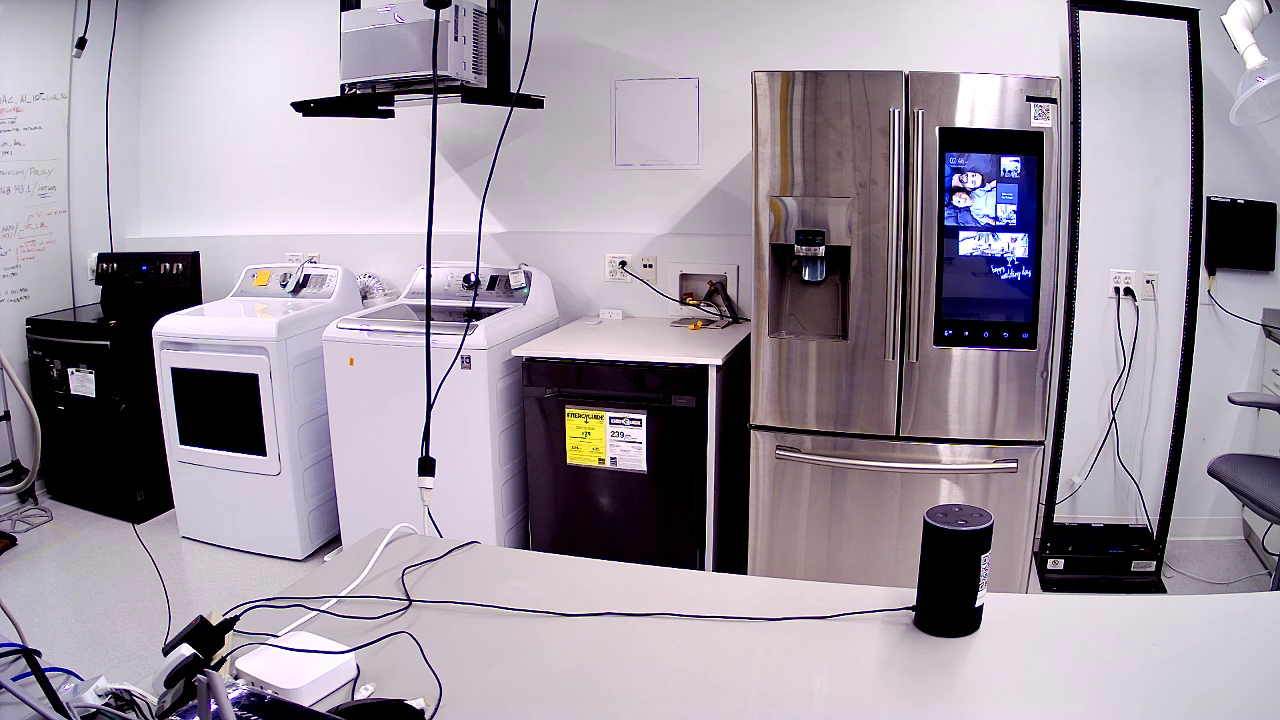

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

label, path = initialize_dataset()[0] #get first video

cap = cv2.VideoCapture(path) #open the video
while(cap.isOpened()):
  ret, frame = cap.read()
  # ret: boolean
  if ret == True:
    cv2_imshow(frame)
    break



We can also look at each individual frame to get a better understanding of the data. Each frame is a 720x1280x3 numpy array:

In [ ]:
frame.shape

(720, 1280, 3)

As a more complicated example, the following code aggregates the first 100 frames into a 4D numpy array (i.e., stacks each frame into a single array):

In [ ]:
import numpy as np
cap = cv2.VideoCapture(path) #open the video

cnt = 0
framelist = []

while(cap.isOpened()):
  ret, frame = cap.read()

  if cnt >= 100:
    break

  if ret == True:
    framelist.append(frame)
  else:
    raise ValueError('Video malformated or too short')
  
  cnt += 1

first_100_frames = np.stack(framelist)
first_100_frames.shape


(100, 720, 1280, 3)

## Setup 3. VideoPose3D
In the first phase, you will use pretrained models from Facebook's VideoPose3D library:
https://github.com/facebookresearch/VideoPose3D
The library takes as input videos of human activities, identifies "keypoints" on the human body, and estimates the 3D position of those keypoints. 

The first step is to install all of the prerequisites.


In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 20 kB/s 
     |████████████████████████████████| 6.6 MB 84.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.


     |████████████████████████████████| 274 kB 7.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c7d96f47fe6441443b9770c0b1243f3aaf7ec71984e0a4a63f0571055a6b1166
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sdnv_zfq
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sdnv_zfq
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264358 sha256=35f477c61d0e6b97a0ff0f969749720b77ac5d4b79a1b54ba42ff86e1a1e7fa4
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5x5mrpy/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4
1.10.0+cu111 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detect

After, installing the pre-requisites we will demonstrate how to use VideoPose3d. The following code changes directories into the VideoPose3d folder and runs inference on a demo video.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/

/content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference


We've placed one demo video in the VideoPose3D folder and the following code runs inference on that video. It takes about 2 mins to complete.

In [ ]:
!python infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir outputs \
    --image-ext mp4 \
    inputs/

model_final_997cc7.pkl: 313MB [00:05, 57.1MB/s]               
Processing inputs/test.mp4
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-l

After running this code, the outputs are stored in the output folder.

In [ ]:
%cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/outputs
os.listdir('.')

/content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/outputs


['MGSampler', 'Classification', 'test.mp4.npz']

These outputs can be loaded into numpy as a standard numpy array. We will show a brief tutorial of how to use this data structure.

In [ ]:
data = np.load('test.mp4.npz',allow_pickle=True)
for d in data.files:
  print(d)

boxes
segments
keypoints
metadata


The main features that we want you to work with are keypoints. The API is a little difficult to use so we have some demo code to retrieve the keypoints

In [ ]:
def extract_trajectories(keypoints):
  trajectory = []
  for _,k in keypoints:
    if len(k) !=0: # removes data where nothing is happening
      three_d_point = k[0,[0,1,3],:] # understand this code!!! look it up in the documentation

      # keypoints: specifies the 2D detections to use. Default: `cpn_ft_h36m_dbb` (CPN fine-tuned on Human 3.6M).

      # The 2D detection source is specified through the --keypoints parameter, which loads the file \
      # data_2d_DATASET_DETECTION.npz from the data directory, where DATASET is the dataset name (e.g. h36m) 
      # and DETECTION is the 2D detection source (e.g. sh_pt_mpii). Since all the files are encoded according to 
      # the same format, it is trivial to create a custom set of 2D detections.

      # the keypoints returns a [# of frames, 2] array, each element is a list
      # according to infer_video_d2.py, 
      # each list item corresponding to each frame is a cls_keyps, which contains two list
      # the first list is: []
      # the second list is: kps
      # kps: concatenation of [kps_xy, kps_logit, kps_prob], in which kps_logit is a dummy variable contains 
      # zeros with the same shape of kps_prob (np.zeros_like), concantenated by axis = 2, which means that the 
      # concatenation is made along the 3rd axis [[:,:,2], [:,:,2], [:,:,2]] = [:,:,6], 
      # and then it was transposed by axis order (0,2,1), so the new kps sequence is:
      # (0,2,1) -> [:,6,:]
      # in this loop, we only read the kps as k, the second index represents the 3d dimension
      # only k[0,[0,1],:] needed
      
      # for every data that has sth happening, get the 3d keypoints and add to the result list
      trajectory.append(three_d_point)

  return trajectory


traj = extract_trajectories(data['keypoints'])

There are 17 keypoints and each keypoint is a 3d point in space. For example, to grab the first time-step, we get the following 3x17 vector

In [ ]:
traj[0]
# traj is a list with len: 104
# each item in traj list is a 3 * 17 array

array([[1.24988342e+03, 1.25370764e+03, 1.25275159e+03, 1.27282935e+03,
        1.27474158e+03, 1.26900513e+03, 1.25657593e+03, 1.25083936e+03,
        1.22884949e+03, 1.18295740e+03, 1.25179553e+03, 1.26900513e+03,
        1.22120081e+03, 1.26231250e+03, 1.23458594e+03, 1.18104529e+03,
        1.18008911e+03],
       [1.36591721e+02, 1.28923416e+02, 1.29881958e+02, 1.45218567e+02,
        1.41384415e+02, 2.53533417e+02, 2.52574890e+02, 4.04023956e+02,
        4.34697174e+02, 5.62182800e+02, 5.51159592e+01, 2.43948044e+02,
        5.91897461e+02, 3.73350739e+02, 4.25111786e+02, 5.67934021e+02,
        5.67934021e+02],
       [9.31548253e-02, 1.50668591e-01, 1.02221057e-01, 1.62046179e-01,
        1.10945500e-01, 9.06409845e-02, 7.44735971e-02, 2.82568038e-02,
        3.90422791e-02, 8.75779614e-02, 6.26626611e-02, 8.61696806e-03,
        1.06980503e-02, 7.60383205e-03, 1.00911865e-02, 2.83088293e-02,
        4.22223732e-02]], dtype=float32)

We can plot one of the dimensions over time to understand how the data looks. For example, the following code plots the 2 of the key point dimensions on a plane

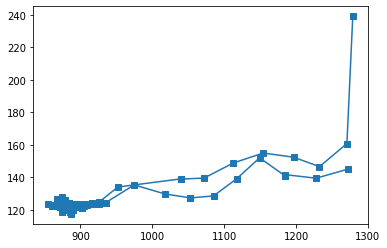

In [ ]:
import matplotlib.pyplot as plt

plot_data = np.stack(traj)
plt.plot(plot_data[:,0,3],plot_data[:,1,3], 's-')
#plot_data.shape

To get this to work on your own notebook, you will have to download the facebook repository and put it in your own google drive. This has to do with "write" permissions.

## Setting up

In [ ]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
!pip install sliced

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 19 kB/s 
     |████████████████████████████████| 6.6 MB 10.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 8.5 MB/s 
  Created wheel fo

In [ ]:
%xmode plain
from google.colab import drive
drive.mount('/content/drive')


import os
import re
import pandas as pd
import numpy as np
os.listdir('/content/drive/My Drive/IOT Classification Challenge/')

PATH = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/'
# os.listdir(PATH)

DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
# os.listdir(DATASET)

from glob import glob

def initialize_dataset():
  result = [y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))]
  labels = [r.split('/')[7] for r in result]
  return list(zip(labels, result))

import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def extract_trajectories(keypoints):
  trajectory = []
  for _,k in keypoints:
    if len(k) !=0: # removes data where nothing is happening
      three_d_point = k[0,[0,1,3],:] # understand this code!!! look it up in the documentation

      # keypoints: specifies the 2D detections to use. Default: `cpn_ft_h36m_dbb` (CPN fine-tuned on Human 3.6M).

      # The 2D detection source is specified through the --keypoints parameter, which loads the file \
      # data_2d_DATASET_DETECTION.npz from the data directory, where DATASET is the dataset name (e.g. h36m) 
      # and DETECTION is the 2D detection source (e.g. sh_pt_mpii). Since all the files are encoded according to 
      # the same format, it is trivial to create a custom set of 2D detections.

      # the keypoints returns a [# of frames, 2] array, each element is a list
      # according to infer_video_d2.py, 
      # each list item corresponding to each frame is a cls_keyps, which contains two list
      # the first list is: []
      # the second list is: kps
      # kps: concatenation of [kps_xy, kps_logit, kps_prob], in which kps_logit is a dummy variable contains 
      # zeros with the same shape of kps_prob (np.zeros_like), concantenated by axis = 2, which means that the 
      # concatenation is made along the 3rd axis [[:,:,2], [:,:,2], [:,:,2]] = [:,:,6], 
      # and then it was transposed by axis order (0,2,1), so the new kps sequence is:
      # (0,2,1) -> [:,6,:]
      # in this loop, we only read the kps as k, the second index represents the 3d dimension
      
      # for every data that has sth happening, get the 3d keypoints and add to the result list
      trajectory.append(three_d_point)

  return trajectory

import matplotlib.pyplot as plt


# !apt-get -q install tree
# !tree .
# !pip install torchvideo
# !pip install pytorchvideo

Exception reporting mode: Plain
Mounted at /content/drive


## TODO 1. Preprocessing
Video activity classification is much easier if all of the videos have the same number of frames. However, notice that the data that we gave you has videos of different lengths.  

Your first TODO is to write a preprocessing function that iterates through all of the videos and subsamples the frames to keep only 100 of them per video. The function should store these subsampled videos in a separate directory. 

You may subsample the video in any way you choose. You may also handle videos shorter than a 100 frames in any way you choose (i.e., blank frames or duplicate the last frame).

This tutorial on writing videos with OpenCV should be helpful:
https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/

In [ ]:
  # # install the mmcv for MGSampler
  # %pip install mmcv
  # # %pip install DPPy

  # # clone the MGSampler repositary
  # # in /content/MGSampler
  # %cd /content
  # !git clone https://github.com/MCG-NJU/MGSampler.git

  # # install build requirements and MMAction2
  # %cd MGSampler/
  # %pip install -r requirements/build.txt
  # %pip install -v -e .

  # # success

In [ ]:
%xmode plain
from types import prepare_class
# assign a directory to store the subsampled videos
DATASET = '/content/drive/My Drive/IOT Classification Challenge/Dataset_1/refrigerator/'
%mkdir '/content/drive/My Drive/IOT Classification Challenge/Subsampled_dataset/'
%mkdir '/content/drive/My Drive/IOT Classification Challenge/Grey_frame_diff/'
path_subsampled_videos = '/content/drive/My Drive/IOT Classification Challenge/Subsampled_dataset/'
path_grey_diff_frame = '/content/drive/My Drive/IOT Classification Challenge/Grey_frame_diff/'
num_videos = len([y for x in os.walk(DATASET) for y in glob(os.path.join(x[0], '*.mp4'))])
print(num_videos)

import re
import time
import torch
import torchvision
import skimage
from skimage import filters
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from torchvision import transforms, utils

%xmode plain

# number of training samples: 220

def preprocess():

    device = "cuda"
    num_frames = 100

    def get_video_filename(video):
        pattern_filename = re.compile(r'(?<=\/[0-9]\/).+?\(.mp4|.mkv)$')
        filename = re.search(pattern_filename, str(video)).group(0)
        return filename
    
    def uniform_sampling():
        '''
        Implement uniform sampling based on OpenCV
        '''
        globals()['error_path_list'] = []
        for _, curr_path in initialize_dataset():
            # load video
            start_time = time.time()
            curr_cap = cv2.VideoCapture(curr_path)
            if curr_cap.isOpened() == True:   # Check the capture that feeds correctly
                video_length = int(curr_cap.get(7)) # Get number of frames   
                video_width = int(curr_cap.get(3))
                video_height = int(curr_cap.get(4))  
                print(f'T:{video_length}   W:{video_width}   H:{video_height}') 
                curr_stride = int(video_length / 100)
                cnt = 0
                frame_list = []
                while(curr_cap.isOpened()):
                    ret, frame = curr_cap.read()
                    if cnt >= video_length:
                        break
                # add frames
                if cnt % curr_stride == 0:
                    if ret == True:  # reading succeeded
                        frame_list.append(frame)
                    cnt += 1
                # compelete length to 100
                # duplicate the last frame
                while len(frame_list) < 100:
                    frame_list.append(frame_list[-1])
                # or drop the last frame
                while len(frame_list) > 100:
                    frame_list.pop(-1)
                assert len(frame_list) == 100
                try:
                    uniform_frames = np.stack(frame_list)
                except:
                    print(curr_path)
                    print(video_length)
                    error_path_list.append(curr_path)
                    curr_cap.release()
                try:
                    print(f'Processing:{get_video_filename(curr_path)}    Time Cost: {time.time() - start_time:0.4f}s')
                    print(f'--------------------------------------------------------------------------------------')
                except:
                    print(f'Error:{curr_path}')
                # save the sampled video
                video_name = get_video_filename(curr_path)  # includes ".pdf"
                out = cv2.VideoWriter(
                    path_subsampled_videos + video_name, 
                    cv2.VideoWriter_fourcc('M','J','P','G'), 
                    num_frames, # number of frames 
                    (video_width,video_height) # width * height
                )
                for i in range(100):
                    out.write(frame_list[i])
                # Release the videowriter
                out.release()
            pass
  
  def get_grey_diff_videos(gray_scale = True, stride = 2):
    '''
    Save abs diffed greyscale videos into 'Grey_frame_diff' folder. 
    Plot the histogram of difference distribution
    Set a threshold to split the frames with salient motion
    Make a Guassian sampling on the frames with motion (Density estimation for bimodal distribution in screen_interaction)
    '''
    import sys
    import os
    import gc
    from matplotlib import pyplot as plt
    gc.enable()
    globals()['error_path_list'] = []
    video_cnt = 0


    def filter_by_total_motion(grey_frame_diff_list, original_frame_list):
      '''
      Estimate the 1d kernel density. 
      Sampling 100 frames by weighted sampling
      Weight generated by the pdf
      '''
      from sklearn.neighbors import KernelDensity
      # from scipy.stats import gaussian_kde

      random_state = 42
      # threshold = 8
      # fig, ax = plt.subplots(1, 1, figsize = (8,3), dpi = 270)
      # x = np.arange(len(grey_frame_diff_list))
      # y = np.array([np.sum(np.sum(curr_frame_diff)) / 1280 / 720 for curr_frame_diff in grey_frame_diff_list])
      # salient_count = np.sum(y > threshold)
      # # find a threshold with # of frames with salient motion around 150 - 200
      # print(f'In video {get_video_filename(curr_path)}, # of salient motion frames: {salient_count}')
      # ax.hist(
      #     y, bins = 100
      # )
      # ax.set_title(video_cnt)
      # ax.axhline(threshold)
      selected_frame_list = []
      # reconstruct the data
      x = np.arange(len(grey_frame_diff_list))
      y = np.array([np.sum(np.sum(curr_frame_diff)) / 1280 / 720 for curr_frame_diff in grey_frame_diff_list])
      distribution_list = np.array(y).reshape(-1, 1)
      KDE = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(distribution_list)
      # KDE = gaussian_kde(dataset = y)
      # weighted sampling
      from numpy.random import choice
      draw = choice(
          a = x, 
          size = 100, 
          replace = False, 
          p = [y[i] / np.sum(y) for i in x]
      )
      selected_frame_index_list = sorted(list(draw))
      assert len(selected_frame_index_list) == 100
      # print(len(original_frame_list))
      # print(draw)
      # reopen the capture and add the original frames
      cnt_original = 0
      curr_cap = cv2.VideoCapture(curr_path)
      if curr_cap.isOpened() == True: 
        while(curr_cap.isOpened()):
          ret, frame = curr_cap.read()
          if ret == True:  # reading succeeded
            if cnt_original in selected_frame_index_list:
              selected_frame_list.append(frame)
          cnt_original += 1
          if cnt_original >= video_length:
            break                    

      assert len(selected_frame_list) == 100
      return selected_frame_list


    for _, curr_path in initialize_dataset():
      # load video
      start_time = time.time()
      curr_cap = cv2.VideoCapture(curr_path)
      if curr_cap.isOpened() == True:   # Check the capture that feeds correctly
        video_length = int(curr_cap.get(7)) # Get number of frames   
        video_width = int(curr_cap.get(3))
        video_height = int(curr_cap.get(4))  
        print(f'T:{video_length}   W:{video_width}   H:{video_height}') 
        cnt = 0
        # Initialize absolute frame difference with the difference in the first frame = 0
        original_frame_list = []
        grey_frame_diff_list = []
        threshold = 150  # CV on this? 
        # Get the full frame list
        while(curr_cap.isOpened()):
          ret, frame = curr_cap.read()
          if ret == True:  # reading succeeded
            if cnt % stride == 0:
              grey_frame = cv2.cvtColor(src = frame, code = cv2.COLOR_BGR2GRAY)
              if cnt == 0:
                init_frame = grey_frame
                # init_frame = torch.tensor(init_frame).cuda()
                curr_frame_diff = np.zeros((720, 1280))
                prev_frame = init_frame
                original_frame_list.append(frame)
              else:
                original_frame_list.append(frame)
                # Add the new frame if it has enough motion base on absdiff with the first frame
                # # Onto GPU
                # grey_frame = torch.tensor(grey_frame).cuda()
                # curr_frame_diff_cuda = abs(grey_frame - init_frame)
                # curr_frame_diff_cuda = abs(grey_frame - prev_frame)
                # update previous frame
                prev_frame = grey_frame
                curr_frame_diff = cv2.absdiff(grey_frame, init_frame)
                # curr_frame_diff = cv2.subtract(grey_frame, init_frame)
                # curr_frame_diff = curr_frame_diff_cuda.cpu()
                # curr_frame_diff = curr_frame_diff.numpy()
                boolean_frame_diff = curr_frame_diff > threshold
                where_diff = np.where(boolean_frame_diff)
                # if cnt % 100 == 0:
                #   cv2_imshow(curr_frame_diff) # still noisy?
                  # plt.imshow(filters.prewitt(curr_frame_diff))
                  # print(boolean_frame_diff)
                # if curr_frame_diff_cuda > threshold:
                #   selected_frame_list.append(grey_frame)

          cnt += 1
          grey_frame_diff_list.append(curr_frame_diff)
          if cnt >= video_length:
            break
        curr_cap.release()
        video_cnt += 1
        selected_frame_list = filter_by_total_motion(grey_frame_diff_list, original_frame_list)
        try:
          selected_frame_list = np.stack(selected_frame_list)
          print(f'The size of grey_frame_diff_list is: {int(sys.getsizeof(grey_frame_diff_list)) / 1024 / 1024:0.4f} MB. ')
          # grey_frame_diff_array = np.stack(grey_frame_diff_list) # Too large! RAM full!
          # video_name = get_video_filename(curr_path) 
          # np.savez(path_grey_diff_frame + video_name, grey_frame_diff_list = grey_frame_diff_list)
        except:
          print(curr_path)
          print(video_length)
          error_path_list.append(curr_path)  
          break

        
        # # save the greyscaled and differenced video
        # video_name = get_video_filename(curr_path)  # includes ".pdf"
        # # Only write greyscale video frame
        # out = cv2.VideoWriter(
        #     path_grey_diff_frame + video_name, 
        #     cv2.VideoWriter_fourcc('M','J','P','G'), 
        #     video_length, # number of frames 
        #     (video_width,video_height), # width * height
        #     False # isColor
        # )
        # for i in range(video_length):
        #   # frame = np.uint8(255 * grey_frame_diff_list[i])
        #   out.write(grey_frame_diff_list[i].astype('uint8'))
        # # Release the videowriter
        # out.release()

        # save the sampled video
        video_name = get_video_filename(curr_path)  # includes ".pdf"
        out = cv2.VideoWriter(
            path_subsampled_videos + video_name, 
            cv2.VideoWriter_fourcc('M','J','P','G'), 
            num_frames, # number of frames 
            (video_width,video_height) # width * height
        )
        for i in range(100):
          out.write(selected_frame_list[i])
        # Release the videowriter
        out.release()



        try:
          # assert len(os.listdir(path_grey_diff_frame)) == video_cnt
          print(f'Processing {video_cnt} of {num_videos}')
          print(f'Processing:{get_video_filename(curr_path)}    Time Cost: {time.time() - start_time:0.4f}s')
          # print(f'Frame differences are: {:0.2f}')
          print(f'--------------------------------------------------------------------------------------')
        except:
          print(f'Error:{curr_path}')
        # Release RAM
        del grey_frame_diff_list
    pass
  
    def motion_guided_sampling():
        get_grey_diff_videos(gray_scale = True, stride = 2)
        pass




    def get_full_feature_data(feature_dirs, transform=None, **kwargs):
        features = []
        labels = []
        label_encoder = {'no_interaction': 0, 'open_close_fridge': 1,
                        'put_back_item': 2, 'screen_interaction': 3, 'take_out_item': 4}

        for path in feature_dirs:
            label = path.split('/')[-2]
            d = np.load(path, allow_pickle=True)
            traj = extract_trajectories(d['keypoints'], with_index=False)
            if transform:
                traj = transform(traj, **kwargs)
            labels.append(label_encoder.get(label, None))
            features.append(traj)

        return features, np.stack(labels)


    def get_correctly_ordered_prediction_filelist():
        import os
        PATH = EVALUATION_VIDEO_PATH

        filelist = []
        for root, dirs, files in os.walk(os.path.abspath(PATH)):
            for file in files:
                filelist.append(os.path.join(root, file))

        filelistunordered = []
        for i in filelist:
            if '.mp4' in i:
                filelistunordered.append(i)

        filelist_evalids = []
        for i in filelistunordered:
            splitfilelist = i.split("_")
            filelist_evalids.append(int(splitfilelist[len(splitfilelist)-2]))

        filelist_evalids.sort()

        predictionfiles = []
        for i in filelist_evalids:
            for j in filelistunordered:
                if j.find(str(i)) > 0:
                    predictionfiles.append(j)
        return predictionfiles






  # uniform_sampling()  
  motion_guided_sampling()
  pass


# dim in torchvision: vframes (Tensor[T, H, W, C])
# definition: 1280 * 720

# # Get the label from the filenames of videos
preprocess()

Exception reporting mode: Plain
mkdir: cannot create directory ‘/content/drive/My Drive/IOT Classification Challenge/Subsampled_dataset/’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/IOT Classification Challenge/Grey_frame_diff/’: File exists
220
Exception reporting mode: Plain
T:513   W:1280   H:720


KeyboardInterrupt: ignored

## TODO 2. Featurization
In the next step, you will write a function that applies the VideoPose3D model to each subsampled video. The example above will help you understand how to use the library and what the outputs are. The output should be a directory of .npz files corresponding to the features. 

Keypoints: https://github.com/jin-s13/COCO-WholeBody/blob/master/imgs/Fig2_anno.png
![](https://github.com/jin-s13/COCO-WholeBody/blob/master/imgs/Fig2_anno.png?raw=true)

In [ ]:
# coco_metadata = {
#     'layout_name': 'coco',
#     'num_joints': 17,
#     'keypoints_symmetry': [
#         [1, 3, 5, 7, 9, 11, 13, 15],
#         [2, 4, 6, 8, 10, 12, 14, 16],
#     ]
# }

# "keypoints" is a length 3*17 array (x, y, v) for body keypoints. \
# Each keypoint has a 0-indexed location x,y and a visibility flag \
# v defined as v=0: not labeled (in which case x=y=0), v=1: labeled\
#  but not visible, and v=2: labeled and visible. A keypoint is \
#  considered visible if it falls inside the object segment.

# 0: HeadCentral -> not symmetric
# 1: LeftEye
# 2: RightEye
# 3: LeftEar
# 4: RightEar
# 5: LeftArmProximal
# 6: RightArmProximal
# 7: LeftArmDistal
# 8: RightArmDistal
# 9: LeftWrist
# 10: RightWrist
# 11: LeftUpperLegProximal
# 12: RightUppeLegProximal
# 13: LeftUpperLegDistal
# 14: RightUpperLegDistal
# 15: LeftAnkle
# 16: RightAnkle


# !python infer_video_d2.py \
#     --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
#     --output-dir outputs \
#     --image-ext mp4 \
#     inputs/

# In infer_video_d2:
            # if has_bbox:
            #     kps = outputs.pred_keypoints.numpy()
            #     kps_xy = kps[:, :, :2]
            #     kps_prob = kps[:, :, 2:3]
            #     kps_logit = np.zeros_like(kps_prob) # Dummy
            #     kps = np.concatenate((kps_xy, kps_logit, kps_prob), axis=2)
            #     kps = kps.transpose(0, 2, 1)


In [ ]:
def featurize():
  '''
  Featurize: design final feature vector after 3-D keypoints processing.
      Input: a directory of subsampled video
     Output: store the output in a directory of .npz files for each video
  '''
  import time
  import re
  %mkdir '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/'
  # %mkdir '/content/Featurized_dataset/'
  path_features = '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/'
  # path_features = '/content/Featurized_dataset/'
  %xmode plain

  # # get 2d keypoints
  # def subsampled_dataset():
  #   result = [y for x in os.walk(path_subsampled_videos) for y in glob(os.path.join(x[0], '*.mp4'))]
  #   pattern_subsampled = re.compile(r'[a-z]+_[a-z]+(_[a-z]+)?(?:_)')
  #   # in TODO 3?
  #   labels = [re.match(pattern_subsampled, result_item) for result_item in result]
  #   return list(zip(labels, result))
  
  # # implement VideoPose3D
  # %cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/
  # !python infer_video_d2.py \
  #   --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
  #   --output-dir '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/' \
  #   --image-ext mp4 \
  #   '/content/drive/My Drive/IOT Classification Challenge/Subsampled_dataset/'

  # Finished! All .npz files are in '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/'
  # Finished! All .npz files are in '/content/Featurized_dataset/'
  
  # processing .npz files
  %cd '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset'
  # %cd '/content/Featurized_dataset'

  def extract_trajectories(keypoints):
    '''
    Do not discard frames that nothing happened. 
    Fill it with previous 3d points. 
    '''
    trajectory = []
    prev_traj = np.zeros((2,17))
    for _,k in keypoints:
      if len(k) !=0:
        # three_d_point = k[0,[0,1,3],:] 
        # only use xy
        three_d_point = k[0,[0,1],:] 
        trajectory.append(three_d_point)
        # prev_traj = three_d_point
      else:
        trajectory.append(prev_traj)
    return trajectory

  # select only upperArm and lowerArm on both left and right sides
  arm_motion_index_list = np.linspace(start = 4, stop = 11, num = 8, dtype = int)
  npz_list = [y for x in os.walk(path_features) for y in glob(os.path.join(x[0], '*.mp4.npz'))]
  print(npz_list)
  for filename in npz_list:
    start_time = time.time()
    data = np.load(filename, allow_pickle = True)
    temp_keypoints = data['keypoints']
    # extract all trajectories
    temp_traj_list = extract_trajectories(temp_keypoints)
    print(f'Original shape in npz file: {np.array(temp_traj_list).shape}')
    # dimension: (T, 2, 17)
    # only keep the feature of arms
    traj_list_filtered = [single_t_traj[:,arm_motion_index_list] for single_t_traj in temp_traj_list]
    print(f'Only select keypoints of hands/arms: {np.array(traj_list_filtered).shape}')
    # save the new traj_list_filtered into .npz file
    
    # only keypoints of arms
    # np.savez(file = filename + '_filtered', traj_list = traj_list_filtered)

    # all keypoints
    np.savez(file = filename + '_filtered', traj_list = temp_traj_list)
    pattern_filename_featurized = re.compile('(?<=Featurized_dataset\/).+\.npz$')
    print(f'Now processing: {re.search(pattern_filename_featurized, filename).group(0)}      Time Cost: {time.time() - start_time:0.4f}s')
    print(f'--------------------------------------------------------------------------------------')

  pass

# featurize()

## Post-process

In [ ]:
def post_process(
    feature_df, 
    label_df, 
    flag = "Train", 
    method = "my_sir", 
    add_predictors = False, 
    n_directions = 80, 
    top_k = 5, 
    n_components = 220
):
  '''
  Implement dimension reduction methods. 
  PCA + SIR
  LDA
  SAVE + PCA
  Contour regression
  '''
  %xmode plain
  import pandas as pd
  import re
  import os
  import numpy as np
  from sklearn.decomposition import PCA
  from sklearn.preprocessing import StandardScaler

  # arm_motion_index_list = np.linspace(start = 4, stop = 11, num = 8, dtype = int)
  # # only keep the feature of arms
  # traj_list_filtered = [single_t_traj[:,arm_motion_index_list] for single_t_traj in temp_traj_list]


  #------------------------------------------------------------------------------------------
  def my_sir(feature_df, label_df, flag = flag, n_directions = n_directions):
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
      print(f'The number of features before post processing: {feature_df.shape}')
      # get slices
      slice_index_dict = {
          1: [], 
          2: [], 
          3: [], 
          4: [], 
          5: []
      }
      for i in np.arange(5):
        slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
        globals()["feature_df_" + str(i + 1)] = feature_df.iloc[slice_index_dict[i + 1],:]
        globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]

      # get sliced cov matrices
      def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered
        return cov

      for i in np.arange(5):
        globals()["cov_" + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])

      # get weighted cov
      weight_df = label_df["label"].value_counts() / label_df.shape[0]
      cov_weighted = np.zeros((feature_df.shape[1], feature_df.shape[1]))
      for i in np.arange(5):
        globals()["weight_cov_" + str(i + 1)] = weight_df.loc[i + 1] * globals()["cov_" + str(i + 1)]
        cov_weighted += globals()["weight_cov_" + str(i + 1)] 

      # pca on weighted cov mat
      u, s, vh = np.linalg.svd(cov_weighted)
      globals()['directions'] = vh[:,:n_directions]
      feature_df_reduced = feature_df @ directions
      print(f'The number of features after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
      feature_df_reduced = feature_df @ globals()['directions']
    return feature_df_reduced

  def my_edr_ver1(feature_df, label_df, flag = flag, n_directions = n_directions):
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
      print(f'The number of features before post processing: {feature_df.shape}')
      # get slices
      slice_index_dict = {
          1: [], 
          2: [], 
          3: [], 
          4: [], 
          5: []
      }
      for i in np.arange(5):
        slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
        globals()["feature_df_" + str(i + 1)] = feature_df.iloc[slice_index_dict[i + 1],:]
        globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
        # get sliced mean vectors
        globals()['mean_' + str(i + 1)] = globals()["feature_df_" + str(i + 1)].mean()

      # concatenate 5 mean vectors
      mean_df = pd.DataFrame(
          data = None, 
          columns = np.arange(feature_df.shape[1], dtype = int)
      )
      for i in np.arange(5):
        mean_df = mean_df.append(pd.DataFrame([globals()['mean_' + str(i + 1)]], columns = mean_df.columns))
      mean_df.index = np.arange(5, dtype = int)

      def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered
        return cov
      
      # get cov of mean_df
      cov_df = get_cov_mat(mean_df)

      # pca on cov mat
      u, s, vh = np.linalg.svd(cov_df)
      globals()['directions'] = vh[:,:n_directions]
      feature_df_reduced = feature_df @ directions
      print(f'The number of features after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
      feature_df_reduced = feature_df @ globals()['directions']
    return feature_df_reduced

  def my_edr_ver2(feature_df, label_df, flag = flag, top_k = top_k):
    feature_df = pd.DataFrame(feature_df)
    if flag == "Train":
      print(f'The number of features before post processing: {feature_df.shape}')
      # get slices
      slice_index_dict = {
          1: [], 
          2: [], 
          3: [], 
          4: [], 
          5: []
      }
      for i in np.arange(5):
        slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
        globals()["feature_df_" + str(i + 1)] = feature_df.iloc[slice_index_dict[i + 1],:]
        globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]

      # get sliced cov matrices
      def get_cov_mat(feature_df):
        from numpy.linalg import pinv
        ones = np.ones((feature_df.shape[0], 1)) # n * 1
        feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
        feature_centered = feature_df - ones @ feature_mean
        # get cov matrix # p * p
        cov = feature_centered.T @ feature_centered
        return cov

      for i in np.arange(5):
        globals()["cov_" + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])
        # implement SVD on each cov mat
        globals()["u_" + str(i + 1)], globals()["s_" + str(i + 1)], globals()["vh_" + str(i + 1)] = np.linalg.svd(globals()["cov_" + str(i + 1)])
        globals()['directions_' + str(i + 1)] = globals()["vh_" + str(i + 1)][:,:top_k]
      
      # concatenate all directions for each slice
      directions = np.concatenate(
          (directions_1, directions_2, directions_3, directions_4, directions_5), 
          axis = 1
      )
      feature_df_reduced = feature_df @ directions
      print(f'The number of features after post processing: {feature_df_reduced.shape}')  
    elif flag == "Test":
      feature_df_reduced = feature_df @ globals()['directions']
    return feature_df_reduced

  def my_pca_edr_ver1(feature_df, label_df, flag = flag, n_directions = n_directions):
    from sklearn.decomposition import PCA
    if flag == "Train":
      globals()['pca'] = PCA(
          n_components = 0.99,
          random_state = 42
      )
      feature_df_pca = globals()['pca'].fit_transform(feature_df, label_df)
    elif flag == "Test":
      feature_df_pca = globals()['pca'].transform(feature_df)
    feature_df_reduced = my_edr_ver1(feature_df_pca, label_df, flag, n_directions = min(feature_df_pca.shape[1], n_directions))
    return feature_df_reduced

  def my_pca_edr_ver2(feature_df, label_df, flag = flag, top_k = top_k):
    from sklearn.decomposition import PCA
    if flag == "Train":
      globals()['pca'] = PCA(
          n_components = 0.99,
          random_state = 42
      )
      feature_df_pca = globals()['pca'].fit_transform(feature_df, label_df)
    elif flag == "Test":
      feature_df_pca = globals()['pca'].transform(feature_df)
    feature_df_reduced = my_edr_ver2(feature_df_pca, label_df, flag, top_k = min(feature_df_pca.shape[1], top_k))
    return feature_df_reduced

  def my_pca_sir(feature_df, label_df, flag = flag, n_directions = n_directions):
    from sklearn.decomposition import PCA
    if flag == "Train":
      globals()['pca'] = PCA(
          n_components = 0.99,
          random_state = 42
      )
      feature_df_pca = globals()['pca'].fit_transform(feature_df, label_df)
    elif flag == "Test":
      feature_df_pca = globals()['pca'].transform(feature_df)
    feature_df_reduced = my_sir(feature_df_pca, label_df, flag, n_directions = min(feature_df_pca.shape[1], n_directions))
    return feature_df_reduced

  def my_baseline(feature_df, label_df, flag = flag, n_components = n_components):
    from sklearn.decomposition import PCA
    if flag == "Train":
      globals()['pca'] = PCA(
          n_components = n_components,
          random_state = 42
      )
      feature_df_pca = globals()['pca'].fit_transform(feature_df, label_df)
    elif flag == "Test":
      feature_df_pca = globals()['pca'].transform(feature_df)
    return feature_df_pca

  #------------------------------------------------------------------------------------------




  # def my_sir_pca(feature_df, label_df, flag = flag, n_directions = n_directions):
  #   import time
  #   import pandas as pd
  #   import numpy as np
  #   from sklearn.model_selection import KFold
  #   from sklearn.model_selection import GridSearchCV
  #   from sklearn.linear_model import LogisticRegression
  #   from sklearn.metrics import accuracy_score
  #   from sklearn.pipeline import Pipeline
  #   from sklearn.decomposition import PCA
  #   if flag == "Train":
  #     print(f'The number of features before post processing: {feature_df.shape}')
  #     inte_df = pd.concat([feature_df, label_df], axis = 1)
  #     # get ranks
  #     var_df = inte_df.groupby(by = "label").var() # n_label * n_predictor
  #     # get weights
  #     weight_df = label_df["label"].value_counts() / label_df.shape[0]
  #     var_df = var_df.T
  #     # Find which dimensions to keep
  #     # weighted by the proportion of labels
  #     globals()['weighted_var_df'] = pd.DataFrame(
  #         data = None, 
  #         index = var_df.index, 
  #         dtype = float, 
  #         columns = ["weighted_sum_var"]
  #     )
  #     for index in globals()['weighted_var_df'].index:
  #       sum = 0
  #       for name in var_df.columns:
  #         w_times_var = var_df.loc[index, name] * weight_df[name]
  #         sum += w_times_var
  #       globals()['weighted_var_df'].loc[index, "weighted_sum_var"] = sum

  #     globals()['weighted_var_df'].sort_values(
  #         by = "weighted_sum_var", 
  #         ascending = False, 
  #         inplace = True
  #     )
  #     # Return the first n_directions many of dimensions with lowest variation
  #     globals()['features_to_keep'] = list(globals()['weighted_var_df'].index[:n_directions])
  #     # return feature_df_reduced, features_selected
  #     feature_df_reduced = feature_df.loc[:,globals()['features_to_keep']]
  #     print(f'The number of features after post processing: {feature_df_reduced.shape}')  
  #     globals()['pca_for_my_sir'] = PCA(
  #         n_components = 0.99, 
  #         random_state = 42
  #     )
  #     feature_df_reduced_pca = globals()['pca_for_my_sir'].fit_transform(feature_df_reduced)
  #   elif flag == "Test":
  #     feature_df_reduced = feature_df.loc[:,globals()['features_to_keep']]
  #     feature_df_reduced_pca = globals()['pca_for_my_sir'].transform(feature_df_reduced)
  #   return feature_df_reduced_pca

  # def pca_save(feature_df, label_df, flag):
  #   from sliced import SlicedAverageVarianceEstimation
  #   from sklearn.decomposition import PCA
  #   from sklearn.model_selection import GridSearchCV
  #   if flag == "Test":
  #     # for test data
  #     feature_df_pca = globals()['pca'].transform(feature_df)
  #     feature_df_pca_std = mahalanobis_transformation(feature_df_pca, flag = flag)
  #     feature_df_reduced = globals()['save'].transform(feature_df_pca_std)
  #   else:
      
  #     # modify the feature_df and the label_df
  #     # sliced #: number of classes
  #     print(f'The number of features before post processing: {feature_df.shape}')  # 220 * (number of frames * keypoints * 2d)
  #     globals()['pca'] = PCA(
  #         n_components = feature_df.shape[0], 
  #         random_state = 42
  #     )
  #     feature_df_pca = globals()['pca'].fit_transform(feature_df, label_df)
  #     globals()['std'] = StandardScaler()
  #     feature_df_pca_std = mahalanobis_transformation(feature_df_pca, flag = flag)
  #     feature_df_pca_std = pd.DataFrame(data = feature_df_pca_std, columns = np.arange(feature_df.shape[0]), dtype = float)

  #     n_directions_ = 220
  #     globals()['save'] = SlicedAverageVarianceEstimation(
  #         n_directions = n_directions_, 
  #         n_slices = 5
  #     )
  #     globals()['save'].fit(feature_df_pca_std, np.array(label_df["label"]))
  #     feature_df_reduced = globals()['save'].transform(feature_df_pca_std)
  #     feature_df_reduced = pd.DataFrame(data = feature_df_reduced, columns = np.arange(n_directions_), dtype = float)
  #     print(f'The number of features after post processing: {feature_df_reduced.shape}')  
  #   return feature_df_reduced, globals()['save'].directions_, globals()['save'].eigenvalues_

  # def lle(feature_df, label_df):
  #   from sklearn.manifold import LocallyLinearEmbedding
  #   from sklearn.model_selection import GridSearchCV
  #   # print(feature_df.shape) 
  #   # print(feature_df.head)
  #   # print(label_df)
  #   feature_df_reduced = feature_df

  #   params_lle = {
  #       'n_neightbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25], 
  #       'n_components': list(np.arange(2, 120, dtype = int))
  #   }

  #   # lle = LocallyLinearEmbedding(
  #   #     n_neighbors = 15, 
  #   #     n_components = 20
  #   # )

  #   gridsearch = GridSearchCV(
  #       esimator = LocallyLinearEmbedding(), 
  #       param_grid = params_lle, 
  #       scoring = LocallyLinearEmbedding().reconstruction_error_, 
  #       cv = 5
  #   )
  #   # make my own metric
  #   gridsearch.fit(X = feature_df, y = None)
  #   print(f'Best reconstruction error is: {gridsearch.best_score_}')
  #   print(f'Best parameter combination is: {gridsearch.best_params_}')

  #   feature_df_reduced = gridsearch.best_estimator_.transform(feature_df)
  #   print(f'Shape of transformed feature_df: {feature_df_reduced.shape}')
  #   # print(f'The reconstruction error is: {gridsearch.best_estimator_.reconstruction_error_}')

  #   # make 2d embedding for each frame? then combine them together
  #   # for each video: 100 * 2 features
  #   return feature_df_reduced

  def add_syncthetic_predictor(feature_df, label_df):
    '''
    Add syncthetic predictors
    1. the standard deviation ratio b/w arm and head within 5 frames before and after
    2. the standard deviation ratio b/w arm and torso within 5 frames before and after
    3. the standard deviation ratio b/w arm and leg within 5 frames before and after
    4. the standard deviation ratio b/w arm proximal and distal (shoulder and wrist) within 5 frames before and after
    '''
    pass


  if add_predictors == True:
    pass

  if method =="sir":
    feature_df_reduced, sir_directions, sir_eigenvalues = pca_sir(feature_df, label_df, flag)
    feature_df_reduced = pd.DataFrame(feature_df_reduced)
    return feature_df_reduced, sir_directions, sir_eigenvalues
  elif method == "save":
    feature_df_reduced, save_directions, save_eigenvalues = pca_save(feature_df, label_df, flag)
    feature_df_reduced = pd.DataFrame(feature_df_reduced)
    print(f'Directions: \n{save_directions}\nEigenvalues: {save_eigenvalues}')
    return feature_df_reduced, save_directions, save_eigenvalues
  elif method == "lle":
    feature_df_reduced = lle(feature_df, label_df, flag)
  elif method == "my_sir":
    feature_df_reduced = my_sir(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag,
        n_directions = n_directions
    )
    feature_df_reduced = pd.DataFrame(feature_df_reduced)
    return feature_df_reduced
  elif method == "my_pca_sir":
    feature_df_reduced = my_pca_sir(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag, 
        n_directions = n_directions
    )
    return feature_df_reduced
  elif method == "my_edr_ver1":
    feature_df_reduced = my_edr_ver1(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag, 
        n_directions = n_directions
    )
    return feature_df_reduced
  elif method == "my_edr_ver2":
    feature_df_reduced = my_edr_ver2(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag, 
        top_k = top_k
    )
    return feature_df_reduced
  elif method == "my_pca_edr_ver1":
    feature_df_reduced = my_pca_edr_ver1(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag, 
        n_directions = n_directions
    )
    return feature_df_reduced
  elif method == "my_pca_edr_ver2":
    feature_df_reduced = my_pca_edr_ver2(
        feature_df = feature_df, 
        label_df = label_df, 
        flag = flag, 
        top_k = top_k
    )
    return feature_df_reduced
  elif method == "my_baseline":
    feature_df_reduced = my_baseline(
      feature_df = feature_df, 
      label_df = label_df, 
      flag = flag, 
      n_components = n_components
    )

  feature_df_reduced = pd.DataFrame(feature_df_reduced)
  return feature_df_reduced

##### Methods
SIR: Based on weighted cov mat, weights generated by the proportion of labels belonging to specific classes, pick top n_directions 

EDR_ver1: Compute mean vectors corresponding to each label, then calculate the cov mat of these means, use SVD and pick top n_directions as the EDR directions

EDR_ver2: Keep top k directions in each slice after SVD and pinv, return a number of directions equal to n_labels * top_k 


## TODO 3. Create a Dataset
Next, you will aggregate all of this preprocessed data into numpy arrays that can be used for machine learning. You will now create a training dataset and validation dataset. 

Hint: the tricky part here will be to make sure you can figure out what the label for the file should be!


In [ ]:
%xmode plain
def create_dataset(method = "my_pca_edr_ver1", n_directions = 80, top_k = 5, n_components = 220):
  ''' 
  CreateDataset: creates a training dataset and validation dataset
          Input: Directory with a collection of vectors of fixed dimension for each video
         Output: A training set (X_train,Y_train), a validation (X_test, Y_test)
  '''
  import time
  import os
  import re
  import sklearn
  import pandas as pd
  import numpy as np
  from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import train_test_split
  random_state = 42

  pattern_label = re.compile(r'[a-z]+_[a-z]+(_[a-z]+)?(?=_[0-9])')
  # read npz with _filtered suffix
  # extract the traj_list

  # dimension of features: (100, 2, 8)
  # labels: [
  # 'screen_interaction',
  # 'open_close_fridge',
  # 'put_back_item',
  # 'no_interaction',
  # 'take_out_item']

  # read in single traj_list
  path_features = '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/'
  # path_features = '/content/Featurized_dataset/'
  npz_filtered_list = [y for x in os.walk(path_features) for y in glob(os.path.join(x[0], '*.mp4.npz_filtered.npz'))]
  # initialize the feature df and label df
  feature_df = pd.DataFrame(
      data = None, 
      dtype = float
  )
  label_df = pd.DataFrame(
      data = None, 
      dtype = str
  )
  feature_list = []
  for filename in npz_filtered_list:
    data = np.load(filename, allow_pickle = True)
    temp_feature_list = data['traj_list']
    # create label
    temp_label = str(re.search(pattern_label, filename).group(0))
    # return the raw stacked frames
    feature_list.append(np.array(temp_feature_list))
    # flatten all the features
    temp_feature_flattened = np.array(temp_feature_list).flatten() # return the shape of (3400, )
    # append to their df respectively
    label_df = label_df.append([[temp_label]]) # 220 * 1
    feature_df = feature_df.append([temp_feature_flattened]) # 220 * (number of frames * keypoints * 2d)
  
  globals()['feature_stack'] = np.stack(feature_list)
  print(f'Shape of raw feature stack: {feature_stack.shape}')

  label_df.columns = ['label']
  feature_df.index = np.arange(feature_df.shape[0], dtype = int)
  label_df.index = np.arange(label_df.shape[0], dtype = int)

  label_to_int = {
      'screen_interaction': 1,
      'open_close_fridge': 2,
      'put_back_item': 3,
      'no_interaction': 4,
      'take_out_item': 5
  }
  label_df.index = np.arange(label_df.shape[0], dtype = int)
  for i in np.arange(label_df.shape[0]):
    label_df.loc[i, 'label'] = label_to_int[label_df.loc[i, 'label']]
  label_df['label'] = label_df['label'].astype(int)

  def mahalanobis_transformation(feature_df):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
    feature_centered = feature_df - ones @ feature_mean
    # get cov matrix # p * p
    cov = feature_centered.T @ feature_centered
    u, s, vh = np.linalg.svd(cov) # all real numbers
    # w, v = np.linalg.eig(cov) # generate complex numbers
    # theshold for pinv: 1e-15
    s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
    s_pinv_sqrt = np.array(np.zeros(feature_df.shape[1]))
    for i, item in enumerate(np.diag(s_pinv)):
      if item > 0:
        s_pinv_sqrt[i] = np.sqrt(item)
    sigma_pinv_sqrt = u @ np.diag(s_pinv_sqrt) @ u.T
    feature_df_whitened = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    return feature_df_whitened

  def whiten(feature_df):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
    feature_centered = feature_df - ones @ feature_mean
    # get cov matrix # p * p
    cov = feature_centered.T @ feature_centered
    u, s, vh = np.linalg.svd(cov) # all real numbers
    # w, v = np.linalg.eig(cov) # generate complex numbers
    # theshold for pinv: 1e-15
    s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
    s_pinv_sqrt = np.zeros(feature_df.shape[1])
    for i, item in enumerate(np.diag(s_pinv)):
      if item > 0:
        s_pinv_sqrt[i] = np.sqrt(item)
    sigma_pinv_sqrt = u @ np.diag(s_pinv_sqrt) @ u.T
    feature_df_whitened = (feature_df) @ sigma_pinv_sqrt 
    return feature_df_whitened

  # standardize feature_df
  feature_df_std = mahalanobis_transformation(feature_df)
  #=============================================================================
  # implement dimension reduction here
  feature_df_reduced = post_process(
      feature_df_std, 
      label_df, 
      flag = "Train", 
      method = method, 
      add_predictors = False, 
      n_directions = n_directions, 
      top_k = top_k
  )
  feature_df_reduced = pd.DataFrame(feature_df_reduced)
  #=============================================================================

  # shuffle
  from sklearn.utils import shuffle
  feature_df_shuffled, label_df_shuffled = shuffle(feature_df_reduced, label_df, random_state = 42)
  # train test split
  feature_df_train, feature_df_test, label_df_train, label_df_test = train_test_split(
      feature_df_shuffled, 
      label_df_shuffled, 
      test_size = 0.2,  
      shuffle = True, 
      random_state = random_state
  )
  return (feature_df_train, label_df_train), (feature_df_test, label_df_test)

# Training, Test, directions, eigenvalues = create_dataset(method = "my_sir") # access via Training[0]/[1]
Training, Test = create_dataset(method = "my_baseline", n_directions = 4, top_k = 10, n_components = 220)

Exception reporting mode: Plain
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain


In [ ]:
def get_std_features(feature_stack, margin = 5):
  '''
  Convert raw trajactory to std-based features
  '''
  feature_name_dict = {
    0: 'HeadCentral',
    1: 'LeftEye',
    2: 'RightEye',
    3: 'LeftEar',
    4: 'RightEar',
    5: 'LeftArmProximal',
    6: 'RightArmProximal',
    7: 'LeftArmDistal',
    8: 'RightArmDistal',
    9: 'LeftWrist',
    10: 'RightWrist',
    11: 'LeftUpperLegProximal',
    12: 'RightUppeLegProximal',
    13: 'LeftUpperLegDistal',
    14: 'RightUpperLegDistal',
    15: 'LeftAnkle',
    16: 'RightAnkle'
  }

  from itertools import permutations
  from itertools import combinations
  # get the temporal slides
  for i in np.arange(margin, feature_stack.shape[1] - margin - 1):
    # temporal length: 10
    curr_temporal_slide = feature_stack[:, np.arange((i - margin),min((i + margin), feature_stack.shape[0] - 1), dtype = int),:,:]
    # 220 * 10 * 2 * 17
    def get_cov_value_from_slide(temporal_slide):
      '''
      Use combinations to get all the potential feature pairs for both x and y dimension
      For only one video
      '''
      comb = combinations(range(17), 2)
      

      return



  return

get_std_features(feature_stack, margin = 5)

In [ ]:
from itertools import combinations
comb = combinations(range(17), 2)
print(comb)

In [ ]:
def get_raw_data():
  import time
  import os
  import re
  import sklearn
  import pandas as pd
  import numpy as np
  from sklearn.preprocessing import StandardScaler
  from sklearn.model_selection import train_test_split
  random_state = 42

  pattern_label = re.compile(r'[a-z]+_[a-z]+(_[a-z]+)?(?=_[0-9])')
  # read npz with _filtered suffix
  # extract the traj_list

  # dimension of features: (100, 2, 8)
  # labels: [
  # 'screen_interaction',
  # 'open_close_fridge',
  # 'put_back_item',
  # 'no_interaction',
  # 'take_out_item']

  # read in single traj_list
  path_features = '/content/drive/My Drive/IOT Classification Challenge/Featurized_dataset/'
  # path_features = '/content/Featurized_dataset/'
  npz_filtered_list = [y for x in os.walk(path_features) for y in glob(os.path.join(x[0], '*.mp4.npz_filtered.npz'))]
  # initialize the feature df and label df
  feature_df = pd.DataFrame(
      data = None, 
      dtype = float
  )
  label_df = pd.DataFrame(
      data = None, 
      dtype = str
  )
  for filename in npz_filtered_list:
    data = np.load(filename, allow_pickle = True)
    temp_feature_list = data['traj_list']
    # create label
    temp_label = str(re.search(pattern_label, filename).group(0))
    # flatten all the features
    temp_feature_flattened = np.array(temp_feature_list).flatten() # return the shape of (1600, )
    # append to their df respectively
    label_df = label_df.append([[temp_label]]) # 220 * 1
    feature_df = feature_df.append([temp_feature_flattened]) # 220 * (number of frames * keypoints * 2d)

  globals()['feature_stack'] = np.stack(feature_list)
  print(f'Shape of raw feature stack: {feature_stack.shape}')

  label_df.columns = ['label']
  feature_df.index = np.arange(feature_df.shape[0], dtype = int)
  label_df.index = np.arange(label_df.shape[0], dtype = int)

  label_to_int = {
      'screen_interaction': 1,
      'open_close_fridge': 2,
      'put_back_item': 3,
      'no_interaction': 4,
      'take_out_item': 5
  }
  label_df.index = np.arange(label_df.shape[0], dtype = int)
  for i in np.arange(label_df.shape[0]):
    label_df.loc[i, 'label'] = label_to_int[label_df.loc[i, 'label']]
  label_df['label'] = label_df['label'].astype(int)

  def mahalanobis_transformation(feature_df):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
    feature_centered = feature_df - ones @ feature_mean
    # get cov matrix # p * p
    cov = feature_centered.T @ feature_centered
    # u, s, vh = np.linalg.svd(cov) # all real numbers
    # # theshold for pinv: 1e-15
    # # s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
    # s_pinv_sqrt = np.zeros(feature_df.shape[1])
    # for i, item in enumerate(s):
    #   if item > 0:
    #     s_pinv_sqrt[i] = np.sqrt(1 / item)
    # sigma_pinv_sqrt = u @ np.diag(s_pinv_sqrt) @ u.T
    # feature_df_std = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    w, v = np.linalg.eig(cov) # generate complex numbers
    # s_pinv = pinv(np.diag(w.real), rcond = 1e-15, hermitian = True) # only use the real part
    s_pinv_sqrt = np.zeros(feature_df.shape[1])
    for i, item in enumerate(w.real):
      if item > 0:
        s_pinv_sqrt[i] = np.sqrt(1 / item)
    sigma_pinv_sqrt = v @ np.diag(s_pinv_sqrt) @ v.T
    feature_df_std = (feature_df - ones @ feature_mean) @ sigma_pinv_sqrt 
    return feature_df_std

  def whiten(feature_df):
    # whiten the data
    from numpy.linalg import pinv
    ones = np.ones((feature_df.shape[0], 1)) # n * 1
    feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
    feature_centered = feature_df - ones @ feature_mean
    # get cov matrix # p * p
    cov = feature_centered.T @ feature_centered
    u, s, vh = np.linalg.svd(cov) # all real numbers
    # w, v = np.linalg.eig(cov) # generate complex numbers
    # theshold for pinv: 1e-15
    s_pinv = pinv(np.diag(s), rcond = 1e-15, hermitian = True)
    s_pinv_sqrt = np.zeros(feature_df.shape[1])
    for i, item in enumerate(np.diag(s_pinv)):
      if item > 0:
        s_pinv_sqrt[i] = np.sqrt(item)
    sigma_pinv_sqrt = u @ np.diag(s_pinv_sqrt) @ u.T
    feature_df_whitened = (feature_df) @ sigma_pinv_sqrt 
    return feature_df_whitened

  # standardize feature_df
  feature_df_std = mahalanobis_transformation(feature_df)
  # feature_df_std = whiten(feature_df)
  return feature_df_std, label_df

feature_df, label_df = get_raw_data()

In [ ]:
feature_df.cov()

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/managers.py:1464: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)  # type: ignore[arg-type]


,0,1,2,3,4,5,6,7,8,9,...,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399
0,0.000312,2.825889e-04,2.760218e-04,0.000281,2.787357e-04,0.000272,0.000268,0.000256,0.000245,0.000236,...,4.407209e-07,3.904816e-07,1.788150e-07,-2.057415e-06,-3.097714e-06,-5.330377e-06,-3.497543e-06,-3.438255e-06,-0.000003,-3.025993e-06
1,0.000283,2.956363e-04,2.793734e-04,0.000293,2.789896e-04,0.000292,0.000259,0.000278,0.000227,0.000252,...,-1.702775e-06,-1.522927e-06,-1.471878e-06,-6.718482e-07,9.738327e-07,6.719626e-07,1.808934e-06,1.921329e-06,0.000002,1.871584e-06
2,0.000276,2.793734e-04,3.217160e-04,0.000280,2.781497e-04,0.000270,0.000273,0.000259,0.000268,0.000234,...,-1.647353e-06,-1.131919e-06,-5.009977e-06,-3.069744e-06,-2.181999e-06,-4.882417e-06,-1.964651e-06,-1.720476e-06,-0.000002,-4.234870e-07
3,0.000281,2.928223e-04,2.795747e-04,0.000311,2.901274e-04,0.000310,0.000274,0.000296,0.000238,0.000258,...,-9.760660e-07,-8.263051e-07,2.068278e-06,9.990376e-07,8.706973e-07,2.664395e-06,2.290122e-06,2.481455e-06,0.000003,2.737746e-06
4,0.000279,2.789896e-04,2.781497e-04,0.000290,3.272470e-04,0.000284,0.000328,0.000251,0.000309,0.000232,...,-1.629621e-06,-1.837981e-06,-3.149467e-06,-2.829750e-06,-6.330171e-07,-2.429768e-06,-4.037931e-07,-6.004920e-07,-0.000001,-8.203629e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,-0.000005,6.719626e-07,-4.882417e-06,0.000003,-2.429768e-06,0.000008,-0.000006,0.000008,-0.000013,0.000007,...,2.279824e-05,2.335475e-05,6.551600e-05,6.610958e-05,3.387925e-05,5.836492e-05,4.730086e-05,4.726655e-05,0.000058,5.562227e-05
3396,-0.000003,1.808934e-06,-1.964651e-06,0.000002,-4.037931e-07,0.000005,-0.000003,0.000005,-0.000008,0.000005,...,2.545516e-05,2.533611e-05,4.643754e-05,4.667579e-05,3.958203e-05,4.730086e-05,5.607838e-05,5.622515e-05,0.000066,6.376687e-05
3397,-0.000003,1.921329e-06,-1.720476e-06,0.000002,-6.004920e-07,0.000006,-0.000004,0.000005,-0.000009,0.000006,...,2.540761e-05,2.551331e-05,4.590352e-05,4.660649e-05,3.975879e-05,4.726655e-05,5.622515e-05,5.656892e-05,0.000066,6.408799e-05
3398,-0.000003,1.543349e-06,-1.750455e-06,0.000003,-1.205191e-06,0.000006,-0.000005,0.000006,-0.000010,0.000005,...,3.160712e-05,3.152997e-05,6.235806e-05,6.037833e-05,4.568013e-05,5.767119e-05,6.628386e-05,6.648154e-05,0.000081,7.691339e-05


### Define transformation for newly-added std-based predictors

In [ ]:
# plot animated 2d keypoints
import matplotlib.animation as animation

def random_walk(num_steps, max_step=0.05):
    """Return a 3D random walk as (num_steps, 3) array."""
    start_pos = np.random.random(3)
    steps = np.random.uniform(-max_step, max_step, size=(num_steps, 3))
    walk = start_pos + np.cumsum(steps, axis=0)
    return walk


def update_lines(num, walks, lines):
    for line, walk in zip(lines, walks):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(walk[:num, :2].T)
        line.set_3d_properties(walk[:num, 2])
    return lines


# Data: 40 random walks as (num_steps, 3) arrays
num_steps = 100 # number of frames


# Attaching 3D axis to the figure
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Create lines initially without data
lines = [ax.plot([], [], [])[0] for _ in walks]

# Setting the axes properties
ax.set(xlim3d=(0, 1), xlabel='X')
ax.set(ylim3d=(0, 1), ylabel='Y')

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update_lines, num_steps, fargs=(walks, lines), interval=100)

plt.show()

### Define our own EDR-oriented function

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%xmode plain

print(f'The number of features before post processing: {feature_df.shape}')
# get slices
slice_index_dict = {
    1: [], 
    2: [], 
    3: [], 
    4: [], 
    5: []
}
for i in np.arange(5):
  slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
  globals()["feature_df_" + str(i + 1)] = feature_df.iloc[slice_index_dict[i + 1],:]
  globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]
  # get sliced mean vectors
  globals()['mean_' + str(i + 1)] = globals()["feature_df_" + str(i + 1)].mean()

# concatenate 5 mean vectors
mean_df = pd.DataFrame(
    data = None, 
    columns = np.arange(feature_df.shape[1], dtype = int)
)
for i in np.arange(5):
  mean_df = mean_df.append(pd.DataFrame([globals()['mean_' + str(i + 1)]], columns = mean_df.columns))
mean_df.index = np.arange(5, dtype = int)

def get_cov_mat(feature_df):
  from numpy.linalg import pinv
  ones = np.ones((feature_df.shape[0], 1)) # n * 1
  feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
  feature_centered = feature_df - ones @ feature_mean
  # get cov matrix # p * p
  cov = feature_centered.T @ feature_centered
  return cov

# get cov of mean_df
cov_df = get_cov_mat(mean_df)

# pca on cov mat
u, s, vh = np.linalg.svd(cov_df)
globals()['directions'] = vh[:,:10]
feature_df_reduced = feature_df @ directions
print(feature_df_reduced)

Exception reporting mode: Plain
The number of features before post processing: (220, 3400)
              0            1           2           3            4           5  \
0      0.000000    67.086592   59.776792 -430.091507  1265.730794   82.714617   
1      0.000000   -32.995140  355.299993  152.771146    55.349228    3.378639   
2      0.000000    -1.837977   52.048853    1.208814    37.084292   13.352615   
3      0.000000    -5.048537   64.937639    3.864749    31.152756   10.126349   
4      0.000000    -7.094954   64.983804   13.133835    36.623994   10.625502   
..          ...          ...         ...         ...          ...         ...   
215 -944.755316  1812.267317   14.658947 -941.687866   549.507360  115.294590   
216 -959.146479  1942.354244  -14.538871 -970.516709   597.994065  106.102514   
217 -978.774265  1933.411203   -8.338205 -994.270296   693.697908  136.166356   
218 -946.070493  1910.451468   -4.874226 -962.346361   560.292733  128.849200   
219    0.000000   

In [ ]:
for item in s:
  print(item)

126481346.76784065
5965302.0762235755
3292230.4992011567
2693700.228266752
1.829913514867099e-07
1.6200683269914915e-07
1.382343767707222e-07
1.1858728104518729e-07
1.1828419568546072e-07
1.1476558206903065e-07
1.1233800269380425e-07
9.677068490487261e-08
9.652132015355495e-08
9.59078096661469e-08
8.151498146311718e-08
8.047733153443938e-08
7.44089301064816e-08
7.409606009158134e-08
6.566859010893594e-08
5.520735770902492e-08
5.241961543296452e-08
4.8880084478764044e-08
4.41557095038425e-08
4.345838649143784e-08
4.0364368376068694e-08
3.733362249612868e-08
3.012278893258994e-08
2.6854241999571326e-08
2.2143975020316543e-08
2.0050439968129653e-08
1.996643716848986e-08
1.6199034158448057e-08
1.5770084116298205e-08
1.386924110505111e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2048726213900709e-08
1.2

In [ ]:
# slicing

# get slices
slice_index_dict = {
    1: [], 
    2: [], 
    3: [], 
    4: [], 
    5: []
}
for i in np.arange(5):
  slice_index_dict[i + 1].extend(label_df[label_df["label"] == (i + 1)].index)
  globals()["feature_df_" + str(i + 1)] = feature_df_std.iloc[slice_index_dict[i + 1],:]
  globals()["label_df_" + str(i + 1)] = label_df.loc[slice_index_dict[i + 1], "label"]

# get sliced cov matrices
def get_cov_mat(feature_df):
  from numpy.linalg import pinv
  ones = np.ones((feature_df.shape[0], 1)) # n * 1
  feature_mean = np.array(feature_df.mean()).reshape(-1, 1).T
  feature_centered = feature_df - ones @ feature_mean
  # get cov matrix # p * p
  cov = feature_centered.T @ feature_centered
  return cov

for i in np.arange(5):
  globals()["cov_" + str(i + 1)] = get_cov_mat(globals()["feature_df_" + str(i + 1)])

# get weighted cov
weight_df = label_df["label"].value_counts() / label_df.shape[0]
cov_weighted = np.zeros((3400, 3400))
for i in np.arange(5):
  globals()["weight_cov_" + str(i + 1)] = weight_df.loc[i + 1] * globals()["cov_" + str(i + 1)]
  cov_weighted += globals()["weight_cov_" + str(i + 1)] 

# pca on weighted cov mat
u, s, vh = np.linalg.svd(cov_weighted)
directions = vh[:,:n_directions]
feature_df_transformed = feature_df_std @ directions

In [ ]:
cov_weighted

,0,1,2,3,4,5,6,7,8,9,...,3390,3391,3392,3393,3394,3395,3396,3397,3398,3399
0,8.109803e-11,7.937735e-11,8.258231e-11,8.332511e-11,8.803591e-11,8.210331e-11,9.163473e-11,7.676259e-11,8.925170e-11,6.896828e-11,...,3.907258e-12,3.756105e-12,4.964557e-12,4.747289e-12,3.122136e-12,1.921219e-12,2.245201e-12,2.060349e-12,2.314865e-12,1.801150e-12
1,7.937735e-11,7.826494e-11,8.116102e-11,8.219470e-11,8.628547e-11,8.133740e-11,8.945127e-11,7.628605e-11,8.682004e-11,6.799650e-11,...,3.882859e-12,3.730543e-12,4.734979e-12,4.524380e-12,3.105311e-12,1.925326e-12,2.261595e-12,2.081415e-12,2.358514e-12,1.828233e-12
2,8.258231e-11,8.116102e-11,8.568495e-11,8.536404e-11,9.079202e-11,8.403264e-11,9.516363e-11,7.856968e-11,9.347709e-11,7.009114e-11,...,3.289677e-12,3.236860e-12,3.522384e-12,3.753968e-12,2.124813e-12,7.673560e-13,7.361721e-13,5.965976e-13,5.328932e-13,2.989462e-13
3,8.332511e-11,8.219470e-11,8.536404e-11,8.688983e-11,9.114855e-11,8.603423e-11,9.466132e-11,8.052746e-11,9.167525e-11,7.105493e-11,...,4.261591e-12,4.070471e-12,5.129113e-12,4.794005e-12,3.551375e-12,2.191054e-12,2.700514e-12,2.502037e-12,2.827143e-12,2.326486e-12
4,8.803591e-11,8.628547e-11,9.079202e-11,9.114855e-11,9.751078e-11,8.956944e-11,1.027912e-10,8.339960e-11,1.008882e-10,7.373816e-11,...,4.428564e-12,4.317236e-12,5.744887e-12,5.726897e-12,3.325274e-12,1.953573e-12,2.085169e-12,1.908961e-12,2.033534e-12,1.636348e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,1.921219e-12,1.925326e-12,7.673560e-13,2.191054e-12,1.953573e-12,2.569176e-12,2.451688e-12,2.728790e-12,2.189542e-12,1.846246e-12,...,1.225104e-11,1.197991e-11,1.935495e-11,1.825966e-11,1.425839e-11,1.504913e-11,1.787141e-11,1.777430e-11,2.108946e-11,1.948390e-11
3396,2.245201e-12,2.261595e-12,7.361721e-13,2.700514e-12,2.085169e-12,3.200032e-12,2.216879e-12,3.267427e-12,1.537301e-12,2.540267e-12,...,1.428261e-11,1.390497e-11,2.160991e-11,2.021439e-11,1.733872e-11,1.787141e-11,2.247111e-11,2.235592e-11,2.660077e-11,2.456663e-11
3397,2.060349e-12,2.081415e-12,5.965976e-13,2.502037e-12,1.908961e-12,2.989495e-12,2.064105e-12,3.071927e-12,1.444005e-12,2.387542e-12,...,1.421195e-11,1.384919e-11,2.147325e-11,2.013021e-11,1.724341e-11,1.777430e-11,2.235592e-11,2.224973e-11,2.647366e-11,2.446319e-11
3398,2.314865e-12,2.358514e-12,5.328932e-13,2.827143e-12,2.033534e-12,3.460535e-12,2.110976e-12,3.597596e-12,1.336942e-12,2.823994e-12,...,1.687658e-11,1.644098e-11,2.540422e-11,2.378723e-11,2.048693e-11,2.108946e-11,2.660077e-11,2.647366e-11,3.152346e-11,2.912566e-11


In [ ]:
# n_directions
n_directions = 30
u, s, vh = np.linalg.svd(cov_weighted)
directions = vh[:,:n_directions]
feature_df_transformed = feature_df_std @ directions

In [ ]:
# data_tr = Training[0]
# label_tr = Training[1]
# index_list = label_tr[label_tr["label"] == 1].index
# data_tr.iloc[index_list, :]

## TODO 4. Train a Classifier
In this step, you will train a classification model using the datasets aggregated in the previous step. You may use any model type that you wish (this part is flexible!). You may also use any helper fuctions to do model or parameter search.

In [ ]:
# !pip install XGBoost
# !pip install lightgbm
# !pip install deep-forest

In [ ]:
def train_classifier(Xtrain, Ytrain, Xtest, Ytest):
  '''
      Input: Dataset (n vectors X_i and their labels) that is split into training and test. 
     Output: Model (of whatever family), whatever the suitable format to make predictions.
  '''

  # try stacking
  # use k-fold cross validation
  # tunning hyperparameters with grid search(?)
  # layer1: XGBoost, RF, ExtraTree, AdaBoost, kNN(?)
  # layer2/final classifier: lightGBM
  from sklearn.ensemble import (
      RandomForestClassifier, 
      AdaBoostClassifier, 
      ExtraTreesClassifier, 
      GradientBoostingClassifier
  )
  from sklearn.neighbors import KNeighborsClassifier
  import lightgbm as lgb
  import xgboost as xgb
  # from deepforest import CascadeForestClassifier
  import time
  import pandas as pd
  import numpy as np
  from sklearn.model_selection import KFold
  from sklearn.model_selection import GridSearchCV
  from sklearn.metrics import f1_score
  random_state = 42

  # def lightgbmcv(clf_, n_splits_, data_train_final_, data_test_final_, label_train_final_, label_test_final_):
  #   # use 5-fold
  #   folds = KFold(n_splits = n_splits_)
  #   f1_list = []
  #   booster = []
  #   i = 0
  #   for train_index, test_index in folds.split(data_train_final_, label_train_final_):
  #     start = time.time()
  #     data_train, data_test = data_train_final_.iloc[train_index,:], data_train_final_.iloc[test_index,:]
  #     label_train, label_test = label_train_final_.iloc[train_index,:], label_train_final_.iloc[test_index,:]
  #     gbm_estimator = clf_
  #     if i == 0:
  #       gbm_estimator.fit(
  #         data_train, 
  #         label_train, 
  #         eval_set = [(data_test, label_test)], 
  #         eval_metric = 'f1', 
  #         early_stopping_rounds = 3
  #       )
  #     else:
  #       gbm_estimator.fit(
  #         data_train, 
  #         label_train, 
  #         eval_set = [(data_test, label_test)], 
  #         eval_metric = 'f1', 
  #         early_stopping_rounds = 3, 
  #         init_model = booster[i - 1]
  #       )
  #     booster.append(gbm_estimator)
  #     i += 1
  #     f1_list.append(gbm_estimator.best_score_)
  #     end = time.time()

  #   f1_value = []
  #   for i in range(len(f1_list)):
  #     f1_value.append(f1_list[i]['valid_0']['f1'])
  #   print(f"Final CLF: lightGBM     F1 values: {f1_value}     Average F1: {np.mean(f1_value)}   Time Cost: {end - start:0.4f}s")
  #   print(f'--------------------------------------------------------------------------------------------------')
  #   final_model = booster[-1]

  #   return final_model, f1_value

  def lightgbmcv_alt(clf_, n_splits_, data_final_, label_final_):
    # use 5-fold
    folds = KFold(n_splits = n_splits_)
    f1_list = []
    booster = []
    i = 0
    for train_index, test_index in folds.split(data_final_, label_final_):
      start = time.time()
      data_train, data_test = data_final_.iloc[train_index,:], data_final_.iloc[test_index,:]
      label_train, label_test = label_final_.iloc[train_index,:], label_final_.iloc[test_index,:]
      gbm_estimator = clf_
      gbm_estimator.fit(
        data_train, 
        label_train, 
        eval_set = [(data_test, label_test)], 
        eval_metric = 'multi_logloss', 
        early_stopping_rounds = 3
      )
      booster.append(gbm_estimator)
      i += 1
      f1_list.append(f1_score(
          y_true = label_test, 
          y_pred = gbm_estimator.predict(data_test), 
          labels = np.array([1,2,3,4,5]),
          average = 'micro'
      ))
      end = time.time()

    print(f"Final CLF: lightGBM     F1 values: {f1_list}     Average F1: {np.mean(f1_list):0.4f}   Time Cost: {end - start:0.4f}s")
    print(f'--------------------------------------------------------------------------------------------------')
    final_model = booster[-1]

    return final_model, f1_list


  # out-of-fold prediction
  def pred_oof(clf_, data_train_, label_train_, data_test_):
    n = 5
    oof_train = np.zeros(len(data_train_))
    oof_test = np.zeros(len(data_test_))
    folds = KFold(n_splits = n)
    oof_test_folds = pd.DataFrame(data = np.zeros((len(data_test_), n)), columns = [0,1,2,3,4])
    i = 0
    for (train_index, test_index) in folds.split(data_train_):
      data_tr = data_train_.iloc[train_index,:]
      label_tr = label_train_.loc[train_index]
      label_tr = label_tr.astype(int)
      data_te = data_train_.iloc[test_index,:]
      clf_.fit(data_tr, label_tr)  # label_tr should be int series
      oof_train[test_index] = clf_.predict(data_te)
      oof_test_folds.loc[:,i] = clf_.predict(data_test_)
      i += 1
    oof_test = oof_test_folds.mean(axis = 1)
    return pd.Series(oof_train), pd.Series(oof_test)
  
  def train_stacking_models():
    models = ["rf", "ada", "ext", "xgb", "knn"]
    for model in models:  # models
      start_time = time.time()
      globals()[model + "_oof_train"], globals()[model + "_oof_test"] = pred_oof(
        clf_ = globals()[model], 
        data_train_ = Xtrain, 
        label_train_ = Ytrain, 
        data_test_ = Xtest
      )
      print(f'Now training: {model}      Time Cost: {time.time() - start_time:0.4f}s')
      print(f'--------------------------------------------------------------------------------------------------')
    pass
  
  def generate_data_layer_2():
    models = ["rf", "ada", "ext", "xgb", "knn"]

    globals()["data_train_final"] = pd.DataFrame(data = np.empty((len(globals()["rf_oof_train"]), len(models))), columns = models)
    globals()["data_test_final"] = pd.DataFrame(data = np.empty((len(globals()["rf_oof_test"]), len(models))), columns = models)

    for model in models: # models
      globals()["data_train_final"].loc[:,model] = globals()[model + "_oof_train"]
      globals()["data_test_final"].loc[:,model] = globals()[model + "_oof_test"]

    # combine train and test
    globals()["data_final"] = pd.DataFrame(data = None, columns = models, dtype = float)
    globals()["label_final"] = pd.DataFrame(data = None, columns = models, dtype = int)

    globals()["data_final"] = pd.concat([globals()["data_train_final"], globals()["data_test_final"]], axis = 0, ignore_index = True)
    globals()["label_final"] = pd.concat([Ytrain, Ytest], axis = 0, ignore_index = True)
    globals()["label_final"] = globals()["label_final"].astype(int)
    globals()["label_train_final"] = Ytrain.astype(int)
    globals()["label_test_final"] = Ytest.astype(int)


    # data after concatenation  e.g.   data_final / label_final
    pass

  def train_final_model():
    final_model = "lgb"
    globals()[final_model] = lgb.LGBMClassifier(
      objective = 'multiclass',  
      max_depth = 8, 
      learning_rate = 0.02, 
      n_estimators = 200, 
      reg_alpha = 0.2, 
      silent = True, 
      importance_type = 'gain', 
      metric = 'multi_logloss'
    ) 
    # globals()["lgb"], globals()["f1_value"] = lightgbmcv(
    #   clf_ = globals()["lgb"], 
    #   n_splits_ = 5, 
    #   data_train_final_ = globals()["data_train_final"], 
    #   data_test_final_ = globals()["data_test_final"], 
    #   label_train_final_ = globals()["label_train_final"], 
    #   label_test_final_ = globals()["label_test_final"]
    # )
    globals()["lgb"], globals()["f1_list"] = lightgbmcv_alt(
      clf_ = globals()["lgb"], 
      n_splits_ = 5, 
      data_final_ = globals()["data_final"], 
      label_final_ = globals()["label_final"]
    )
    pass

  def applyGridSearch(estimator_ , parameters_, data_, label_):
    clf = GridSearchCV(
      estimator = estimator_, 
      param_grid = parameters_, 
      n_jobs = -1, 
      verbose = 1, 
      scoring = 'f1', 
      refit = True, 
      cv = 5
    )
    clf.fit(data_, label_)
    return clf.best_estimator_, clf.best_score_, clf.best_params_, clf.cv_results_


  # instantiate classifiers
  globals()["rf"] = RandomForestClassifier(
      n_estimators = 200, 
      criterion = 'gini', 
      max_depth = 8, 
      min_samples_split = 10, 
      max_features = 0.9, 
      warm_start = True, 
      bootstrap = True, 
      n_jobs = -1, 
      verbose = -1, 
      random_state = random_state
  )

  globals()["ada"] = AdaBoostClassifier(
      n_estimators = 200, 
      learning_rate = 0.1, 
      algorithm = 'SAMME.R', 
      random_state = random_state
  )

  globals()["ext"] = ExtraTreesClassifier(
      n_estimators = 200, 
      criterion = 'gini', 
      max_depth = 6, 
      min_samples_leaf = 10, 
      max_features = 0.9, 
      warm_start = True, 
      bootstrap = True, 
      n_jobs = -1, 
      verbose = -1, 
      random_state = random_state
  )

  globals()["xgb"] = xgb.XGBClassifier(
      n_estimators = 200, 
      learning_rate = 0.02, 
      subsample = 0.9, 
      reg_alpha = 0.1, 
      eval_metric = "mlogloss",
      min_samples_leaf = 10, 
      max_depth = 6, 
      max_features = 0.9, 
      verbose = 0, 
      warm_start = True, 
      random_state = random_state, 
      gpu_id = 0, 
      predictor = 'gpu_predictor'
  )

  globals()["knn"] = KNeighborsClassifier(
      n_neighbors = 5, 
      weights = 'distance', 
      p = 2, 
      metric = "minkowski", 
      n_jobs = -1
  )

  # update index
  Xtrain.index = np.linspace(0, len(Xtrain) - 1, len(Xtrain), dtype = int)
  Ytrain.index = np.linspace(0, len(Ytrain) - 1, len(Ytrain), dtype = int)
  Xtest.index = np.linspace(0, len(Xtest) - 1, len(Xtest), dtype = int)
  Ytest.index = np.linspace(0, len(Ytest) - 1, len(Ytest), dtype = int)

  # change label name to int
  label_to_int = {
      'screen_interaction': 1,
      'open_close_fridge': 2,
      'put_back_item': 3,
      'no_interaction': 4,
      'take_out_item': 5
  }
  for i in Ytrain.index:
    Ytrain.loc[i,'label'] = label_to_int[Ytrain.loc[i,'label']]
  for i in Ytest.index:
    Ytest.loc[i,'label'] = label_to_int[Ytest.loc[i,'label']]
  Ytrain = Ytrain.astype(int)
  Ytest = Ytest.astype(int)

  # training
  train_stacking_models()
  generate_data_layer_2()
  train_final_model()


  # clf is a dict
  # clf contains all the classifiers
  clf = {
      "rf": globals()["rf"], 
      "ada": globals()["ada"],
      "ext": globals()["ext"],
      "xgb": globals()["xgb"],
      "knn": globals()["knn"], 
      "lgb": globals()["lgb"], 
      "f1": globals()["f1_list"]
  } 
  
  return clf




def train_classifier_phase2(Xtrain, Ytrain, Xtest, Ytest):
  '''
  Only try to use multiclass logostic regression and random forest
  * Logistic Regression
  Only focus on overall accuracy
  '''
  import time
  import pandas as pd
  import numpy as np
  from sklearn.model_selection import KFold
  from sklearn.model_selection import GridSearchCV
  from sklearn.linear_model import LogisticRegression
  from sklearn.metrics import accuracy_score
  random_state = 42

  # Data perparation
  # update index
  Xtrain.index = np.linspace(0, Xtrain.shape[0] - 1, Xtrain.shape[0], dtype = int)
  Ytrain.index = np.linspace(0, Ytrain.shape[0] - 1, Ytrain.shape[0], dtype = int)
  Xtest.index = np.linspace(0, Xtest.shape[0] - 1, Xtest.shape[0], dtype = int)
  Ytest.index = np.linspace(0, Ytest.shape[0] - 1, Ytest.shape[0], dtype = int)
  # print(Xtrain.index)
  # print(Ytrain.index)

  # # change label name to int
  # label_to_int = {
  #     'screen_interaction': 1,
  #     'open_close_fridge': 2,
  #     'put_back_item': 3,
  #     'no_interaction': 4,
  #     'take_out_item': 5
  # }
  # for i in Ytrain.index:
  #   Ytrain.loc[i,'label'] = label_to_int[Ytrain.loc[i,'label']]
  # for i in Ytest.index:
  #   Ytest.loc[i,'label'] = label_to_int[Ytest.loc[i,'label']]
  # Ytrain = Ytrain.astype(int)
  # Ytest = Ytest.astype(int)

  parameters = {
      'penalty': ['l1', 'l2'], 
      'tol': [1e-4, 1e-8], 
      'C': [10000, 1000, 100, 10, 1, 0.95, 0.9, 0.3, 0.2, 0.1], 
      'random_state': [42], 
      'solver': ['saga'], 
      'max_iter': [100, 150, 200], 
      'verbose': [0], 
      'n_jobs': [-1]
  }

  gridsearch = GridSearchCV(
    estimator = LogisticRegression(), 
    param_grid = parameters, 
    n_jobs = -1, 
    verbose = 1, 
    scoring = 'accuracy', 
    refit = True, 
    cv = 5, 
    return_train_score = True
  )
  gridsearch.fit(Xtrain, np.array(Ytrain).ravel())
  print(f'The best paramters combination is: {gridsearch.best_params_}')
  clf = gridsearch.best_estimator_
  cv_result = gridsearch.cv_results_
  print(f'Test Accuracy: {np.mean(clf.score(Xtest, Ytest)):0.4f}')
  test_score = np.mean(clf.score(Xtest, Ytest))
  best_index = gridsearch.best_index_
  best_train_score = gridsearch.best_score_
  best_validation_score = cv_result['mean_test_score'][best_index]
  best_params = gridsearch.best_params_

  result_df = pd.DataFrame(
      data = [[best_train_score], 
              [best_validation_score],
              [test_score]], 
      columns = ["scores"], 
      index = ["Train", "Validation", "Test"]
  )
  display(result_df)
  return clf, cv_result, result_df, best_params

# clf = train_classifier(Training[0], Training[1], Test[0], Test[1])
# clf, cv_result, score_df, best_param = train_classifier_phase2(
#     Training[0], Training[1], Test[0], Test[1]
# )


In [ ]:
# find the best params index
# best_score is the mean_train_score
# get the best params crresponding train_score and test_score by best_index
# best_train_score = cv_result['mean_train_score'][best_index]
# best_validation_score = cv_result['mean_test_score'][best_index]
# accu_test

## Baseline model

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

params_create_dataset = {
    'n_components': [int(item) for item in np.logspace(0.5, 3, num = 30)]
}
random_state = 42
grid_search_dict = {}
n_directions_list = []
train_error_list = []
test_error_list = []
for key, values in params_create_dataset.items():
  for value in values:
    print(f'Current n_components: {value}')
    globals()['temp_Training'], globals()['temp_Test'] = create_dataset(
        method = "my_baseline", 
        n_components = value
    )
    temp_clf, temp_cv_result, temp_score_df, temp_best_param = train_classifier_phase2(
        globals()['temp_Training'][0], 
        globals()['temp_Training'][1], 
        globals()['temp_Test'][0], 
        globals()['temp_Test'][1]
    )
    temp_best_validation_score = temp_score_df.loc["Validation", "scores"]
    temp_test_score = temp_score_df.loc["Test", "scores"]
    n_directions_list.append(value)
    train_error_list.append(temp_best_validation_score)
    test_error_list.append(temp_test_score)
    grid_search_dict[value] = temp_test_score

# Choose the best n_directions
best_n_directions = max(grid_search_dict, key = grid_search_dict.get)  
print(f'Best n_directions: {best_n_directions}\nBest test accuracy: {grid_search_dict[best_n_directions]}')
print('\n')

Current n_components: 3
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 3
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 4
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 5
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 6
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 8
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 10
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 12
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 15
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 18
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 23
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 28
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 34
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 41
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 50
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 62
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 75
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 92
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 112
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 137
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 167
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 204
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 249
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 303
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 370
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 452
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 551
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 672
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 819
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Current n_components: 1000
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 300, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Test Accuracy: 0.2727


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,scores
Train,0.352063
Validation,0.352063
Test,0.272727


Best n_directions: 3
Best test accuracy: 0.2727272727272727




## Gridsearch

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


params_create_dataset = {
    # around 20 maximize the test accuracy
    # 'n_directions': [4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 100, 200, 300, 400, 600, 1000]
    # 'top_k': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 30, 50, 100]
    'top_k': [int(item) for item in np.logspace(0.1, 2, num = 20)]
}

# parameters = {
#     'penalty': ['l1'], 
#     'tol': [1e-4], 
#     'C': [10000, 1000, 100, 10, 1, 0.95, 0.9], 
#     'random_state': [42], 
#     'solver': ['saga'], 
#     'max_iter': [150, 200, 300, 500], 
#     'verbose': [0], 
#     'n_jobs': [-1]
# }

random_state = 42
grid_search_dict = {}
n_directions_list = []
train_error_list = []
test_error_list = []
for key, values in params_create_dataset.items():
  for value in values:
    globals()['temp_Training'], globals()['temp_Test'] = create_dataset(
        method = "my_pca_edr_ver2", 
        top_k = value
        # n_directions = value
    )
    temp_clf, temp_cv_result, temp_best_index, temp_best_train_score, \
    temp_validation_score, temp_best_param = train_classifier_phase2(
        globals()['temp_Training'][0], 
        globals()['temp_Training'][1], 
        globals()['temp_Test'][0], 
        globals()['temp_Test'][1]
    )
    n_directions_list.append(value)
    train_error_list.append(temp_best_train_score)
    test_error_list.append(temp_validation_score)
    print(f'The best paramters combination is: {temp_best_param}')
    print(f'n_directions: {value}\nAccuracy: {temp_validation_score:0.4f}')
    grid_search_dict[value] = temp_validation_score

# Choose the best n_directions
best_n_directions = max(grid_search_dict, key = grid_search_dict.get)  
print(f'Best n_directions: {best_n_directions}\nBest test accuracy: {grid_search_dict[best_n_directions]}')
print('\n')

Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
The number of features before post processing: (220, 217)
The number of features after post processing: (220, 5)
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 1, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Accuracy: 0.3182
The best paramters combination is: {'C': 1, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
n_directions: 1
Accuracy: 0.3182
Shape of raw feature stack: (220, 100, 2, 17)
Exception reporting mode: Plain
The number of features before post processing: (220, 217)
The number of features after post processing: (220, 5)
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 1, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'sag

KeyboardInterrupt: ignored

### Learning Curve

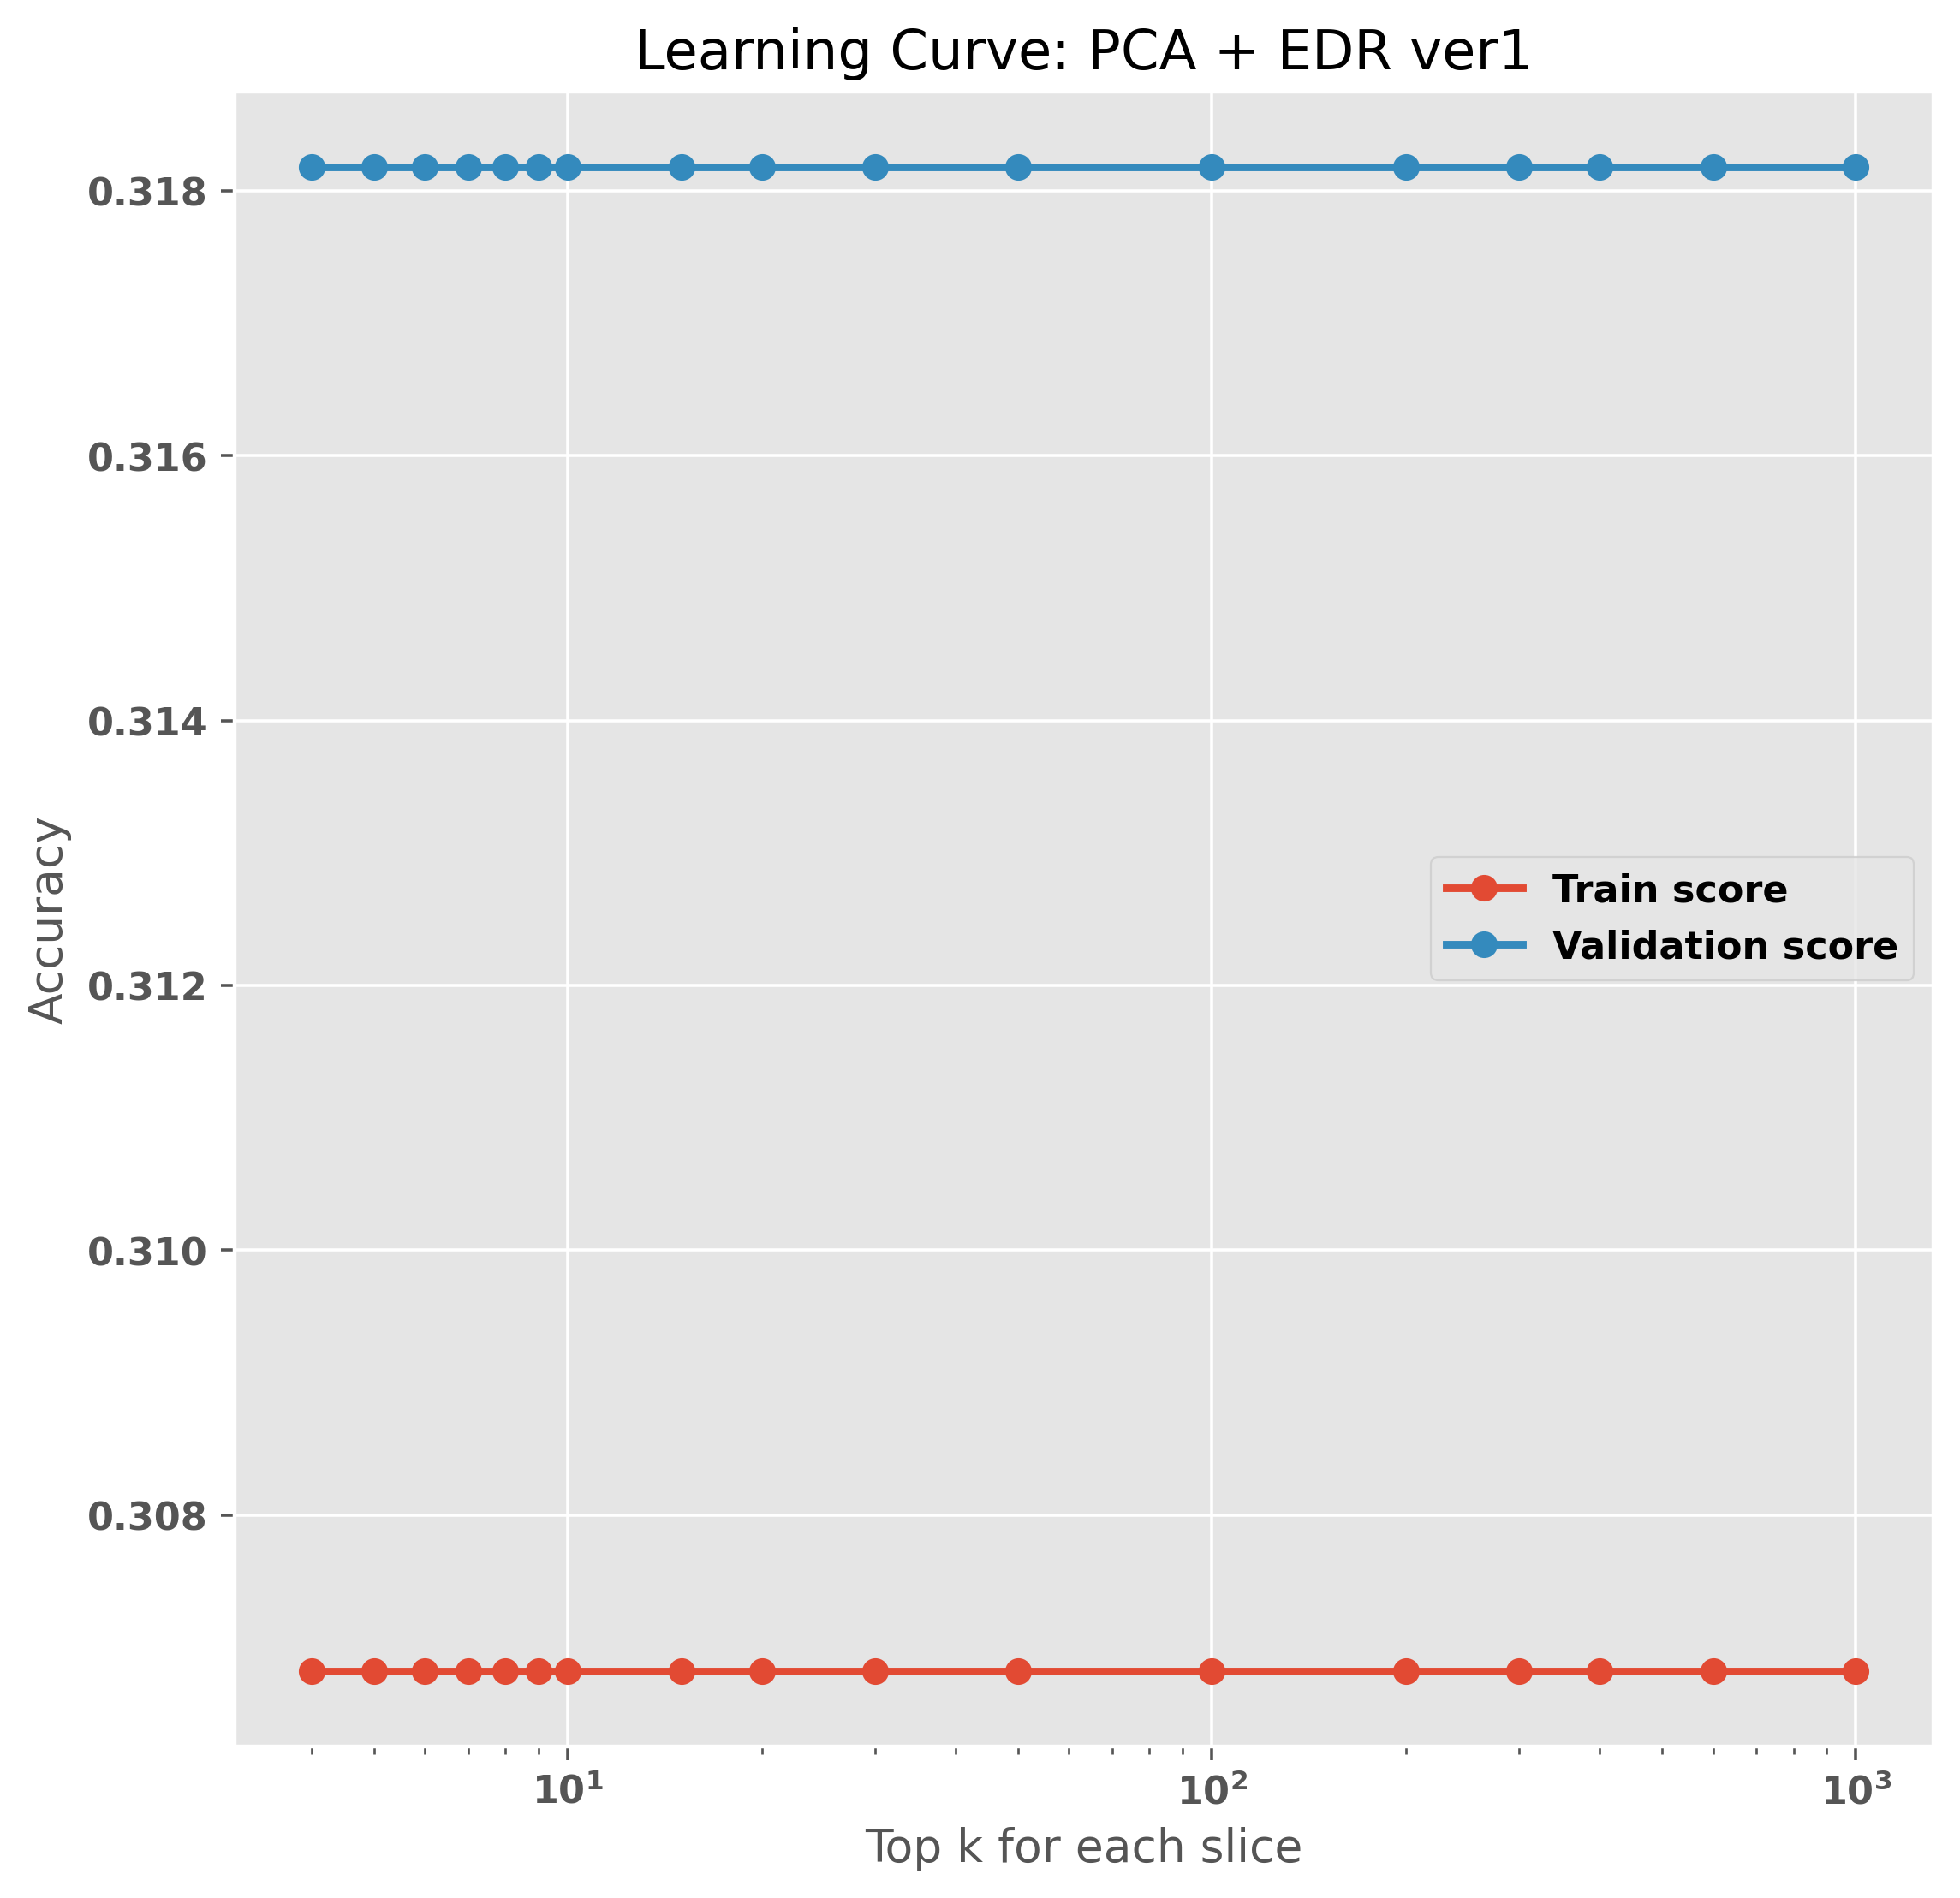

In [ ]:
def plot_learning_curve(n_directions_list, training_score_list, validation_score_list):
  import matplotlib
  from matplotlib import pyplot as plt
  from matplotlib import cm
  plt.rcParams["font.weight"] = "bold"
  plt.style.use('ggplot')
  fig,ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 320)
  ax.plot(n_directions_list, training_score_list, 'o-', label = "Train score", linewidth = 2)
  ax.plot(n_directions_list, validation_score_list, 'o-', label = "Validation score", linewidth = 2)
  ax.legend()
  ax.set_xscale("log")
  ax.set_title('Learning Curve: PCA + EDR ver2')
  ax.set_xlabel('Top k for each slice')
  ax.set_ylabel('Accuracy')
  plt.show()
  pass

plot_learning_curve(
    n_directions_list = n_directions_list,
    training_score_list = train_error_list, 
    validation_score_list = test_error_list
)



#### Use the best combination of hyperparameters

In [ ]:
Training, Test = create_dataset(method = "my_baseline", n_directions = 4, top_k = 5, n_components = )
# pca = PCA(
#     n_components = 0.99, 
#     random_state = 42
# )
# Training_pca = pd.DataFrame(pca.fit_transform(Training[0]))
# Test_pca = pd.DataFrame(pca.transform(Test[0]))
clf, cv_result, best_index, best_train_score, test_score, best_param = train_classifier_phase2(Training[0], Training[1], Test[0], Test[1])

Exception reporting mode: Plain
The number of features before post processing: (220, 217)
The number of features after post processing: (220, 4)
Fitting 5 folds for each of 56 candidates, totalling 280 fits
The best paramters combination is: {'C': 10, 'max_iter': 150, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0}
Accuracy: 0.3409


## TODO 5. Submit Challenge Predictions
Finally, we have provided a test set with unlabeled data in the 'Evaluation_Dataset' folder. We have the appropriate labels for this dataset (that you can't see!). You will be ranked on your performance on this dataset. 

Write a function that iterates through all of the videos in the evaluation dataset, preprocesses them, featurizes them, and then issues a prediction. You will have to figure out how to encapsulate your code to make this easy to do without having to duplicate functions. The output should be dictionary of demonstration id to predicted label.

In [ ]:
def featurize_evaluation_set(sampling = False, featurize = False):
  '''
   Input: a directory of videos corresponding to the evaluation dataset
  Output: a dictionary mapping demonstration id -> feature vector
  '''
  %mkdir '/content/drive/MyDrive/IOT Classification Challenge/Subsampled_Eval'
  %mkdir '/content/drive/MyDrive/IOT Classification Challenge/Featurized_Eval'
  # %mkdir '/content/Subsampled_Eval'
  # %mkdir '/content/Featurized_Eval'
  path_eval_dataset = '/content/drive/MyDrive/IOT Classification Challenge/Evaluation_Dataset'
  path_eval_subsampled = '/content/drive/MyDrive/IOT Classification Challenge/Subsampled_Eval/'
  path_eval_featurized = '/content/drive/MyDrive/IOT Classification Challenge/Featurized_Eval/'
  # path_eval_dataset = '/content/drive/MyDrive/IOT Classification Challenge/Evaluation_Dataset'
  # path_eval_subsampled = '/content/Subsampled_Eval/'
  # path_eval_featurized = '/content/Featurized_Eval/'

  import time
  import re
  import cv2
  %xmode plain


  def get_video_filename_eval(video):
    pattern_filename = re.compile('(?<=\/)unlabeled.+\.mp4')
    filename = re.search(pattern_filename, str(video)).group(0)
    return filename

  def get_video_id(video):
    pattern_id = re.compile('(?<=[0-9]_)[0-9]{10}')
    id = re.search(pattern_id, str(video)).group(0)
    return id

  def uniform_sampling_eval():
    '''
    Implement uniform sampling
    '''
    num_frames = 100
    globals()['error_path_list'] = []
    eval_data_list = [y for x in os.walk(path_eval_dataset) for y in glob(os.path.join(x[0], '*.mp4'))]
    for curr_path in eval_data_list:
      # load video
      start_time = time.time()
      curr_cap = cv2.VideoCapture(curr_path)
      if curr_cap.isOpened() == True:   # Check the capture that feeds correctly
        video_length = int(curr_cap.get(7)) # Get number of frames   
        video_width = int(curr_cap.get(3))
        video_height = int(curr_cap.get(4))  
        print(f'T:{video_length}   W:{video_width}   H:{video_height}') 
        curr_stride = int(video_length / 100)
        cnt = 0
        frame_list = []
        while(curr_cap.isOpened()):
          ret, frame = curr_cap.read()
          if cnt >= video_length:
            break
          # add frames
          if cnt % curr_stride == 0:
            if ret == True:  # reading succeeded
              frame_list.append(frame)
          cnt += 1
        # compelete length to 100
        # duplicate the last frame
        while len(frame_list) < 100:
          frame_list.append(frame_list[-1])
        # or drop the last frame
        while len(frame_list) > 100:
          frame_list.pop(-1)
        assert len(frame_list) == 100
        try:
          uniform_frames = np.stack(frame_list)
        except:
          print(curr_path)
          print(video_length)
          error_path_list.append(curr_path)
        curr_cap.release()
        try:
          print(f'Processing:{get_video_filename_eval(curr_path)}    Time Cost: {time.time() - start_time:0.4f}s')
          print(f'--------------------------------------------------------------------------------------')
        except:
          print(f'Error:{curr_path}')
        # save the sampled video
        video_name = get_video_filename_eval(curr_path)  # includes ".pdf"
        out = cv2.VideoWriter(
            path_eval_subsampled + video_name, 
            cv2.VideoWriter_fourcc('M','J','P','G'), 
            num_frames, # number of frames 
            (video_width,video_height) # width * height
        )
        for i in range(100):
          out.write(frame_list[i])
        # Release the videowriter
        out.release()
    pass
  
  def get_grey_diff_videos_eval(gray_scale = True, stride = 2):
    '''
    Save abs diffed greyscale videos into 'Grey_frame_diff' folder. 
    Plot the histogram of difference distribution
    Set a threshold to split the frames with salient motion
    Make a Guassian sampling on the frames with motion (Density estimation for bimodal distribution in screen_interaction)
    '''
    import sys
    import os
    import gc
    from matplotlib import pyplot as plt
    gc.enable()
    globals()['error_path_list'] = []
    video_cnt = 0
    eval_data_list = [y for x in os.walk(path_eval_dataset) for y in glob(os.path.join(x[0], '*.mp4'))]
    num_videos = len(eval_data_list)


    def filter_by_total_motion(grey_frame_diff_list, original_frame_list):
      '''
      Estimate the 1d kernel density. 
      Sampling 100 frames by weighted sampling
      Weight generated by the pdf
      '''
      from sklearn.neighbors import KernelDensity
      # from scipy.stats import gaussian_kde

      random_state = 42
      # threshold = 8
      # fig, ax = plt.subplots(1, 1, figsize = (8,3), dpi = 270)
      # x = np.arange(len(grey_frame_diff_list))
      # y = np.array([np.sum(np.sum(curr_frame_diff)) / 1280 / 720 for curr_frame_diff in grey_frame_diff_list])
      # salient_count = np.sum(y > threshold)
      # # find a threshold with # of frames with salient motion around 150 - 200
      # print(f'In video {get_video_filename(curr_path)}, # of salient motion frames: {salient_count}')
      # ax.hist(
      #     y, bins = 100
      # )
      # ax.set_title(video_cnt)
      # ax.axhline(threshold)
      selected_frame_list = []
      # reconstruct the data
      x = np.arange(len(grey_frame_diff_list))
      y = np.array([np.sum(np.sum(curr_frame_diff)) / 1280 / 720 for curr_frame_diff in grey_frame_diff_list])
      distribution_list = np.array(y).reshape(-1, 1)
      KDE = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(distribution_list)
      # KDE = gaussian_kde(dataset = y)
      # weighted sampling
      from numpy.random import choice
      draw = choice(
          a = x, 
          size = 100, 
          replace = False, 
          p = [y[i] / np.sum(y) for i in x]
      )
      selected_frame_index_list = sorted(list(draw))
      assert len(selected_frame_index_list) == 100
      # print(len(original_frame_list))
      # print(draw)
      # reopen the capture and add the original frames
      cnt_original = 0
      curr_cap = cv2.VideoCapture(curr_path)
      if curr_cap.isOpened() == True: 
        while(curr_cap.isOpened()):
          ret, frame = curr_cap.read()
          if ret == True:  # reading succeeded
            if cnt_original in selected_frame_index_list:
              selected_frame_list.append(frame)
          cnt_original += 1
          if cnt_original >= video_length:
            break                    

      assert len(selected_frame_list) == 100
      return selected_frame_list


    for curr_path in eval_data_list:
      # load video
      start_time = time.time()
      curr_cap = cv2.VideoCapture(curr_path)
      if curr_cap.isOpened() == True:   # Check the capture that feeds correctly
        video_length = int(curr_cap.get(7)) # Get number of frames   
        video_width = int(curr_cap.get(3))
        video_height = int(curr_cap.get(4))  
        print(f'T:{video_length}   W:{video_width}   H:{video_height}') 
        cnt = 0
        # Initialize absolute frame difference with the difference in the first frame = 0
        original_frame_list = []
        grey_frame_diff_list = []
        threshold = 150  # CV on this? 
        # Get the full frame list
        while(curr_cap.isOpened()):
          ret, frame = curr_cap.read()
          if ret == True:  # reading succeeded
            if cnt % stride == 0:
              grey_frame = cv2.cvtColor(src = frame, code = cv2.COLOR_BGR2GRAY)
              if cnt == 0:
                init_frame = grey_frame
                # init_frame = torch.tensor(init_frame).cuda()
                curr_frame_diff = np.zeros((720, 1280))
                prev_frame = init_frame
                original_frame_list.append(frame)
              else:
                original_frame_list.append(frame)
                # Add the new frame if it has enough motion base on absdiff with the first frame
                # # Onto GPU
                # grey_frame = torch.tensor(grey_frame).cuda()
                # curr_frame_diff_cuda = abs(grey_frame - init_frame)
                # curr_frame_diff_cuda = abs(grey_frame - prev_frame)
                # update previous frame
                prev_frame = grey_frame
                curr_frame_diff = cv2.absdiff(grey_frame, init_frame)
                # curr_frame_diff = cv2.subtract(grey_frame, init_frame)
                # curr_frame_diff = curr_frame_diff_cuda.cpu()
                # curr_frame_diff = curr_frame_diff.numpy()
                boolean_frame_diff = curr_frame_diff > threshold
                where_diff = np.where(boolean_frame_diff)
                # if cnt % 100 == 0:
                #   cv2_imshow(curr_frame_diff) # still noisy?
                  # plt.imshow(filters.prewitt(curr_frame_diff))
                  # print(boolean_frame_diff)
                # if curr_frame_diff_cuda > threshold:
                #   selected_frame_list.append(grey_frame)

          cnt += 1
          grey_frame_diff_list.append(curr_frame_diff)
          if cnt >= video_length:
            break
        curr_cap.release()
        video_cnt += 1
        selected_frame_list = filter_by_total_motion(grey_frame_diff_list, original_frame_list)
        try:
          selected_frame_list = np.stack(selected_frame_list)
          print(f'The size of grey_frame_diff_list is: {int(sys.getsizeof(grey_frame_diff_list)) / 1024 / 1024:0.4f} MB. ')
          # grey_frame_diff_array = np.stack(grey_frame_diff_list) # Too large! RAM full!
          # video_name = get_video_filename(curr_path) 
          # np.savez(path_grey_diff_frame + video_name, grey_frame_diff_list = grey_frame_diff_list)
        except:
          print(curr_path)
          print(video_length)
          error_path_list.append(curr_path)  
          break

        
        # # save the greyscaled and differenced video
        # video_name = get_video_filename(curr_path)  # includes ".pdf"
        # # Only write greyscale video frame
        # out = cv2.VideoWriter(
        #     path_grey_diff_frame + video_name, 
        #     cv2.VideoWriter_fourcc('M','J','P','G'), 
        #     video_length, # number of frames 
        #     (video_width,video_height), # width * height
        #     False # isColor
        # )
        # for i in range(video_length):
        #   # frame = np.uint8(255 * grey_frame_diff_list[i])
        #   out.write(grey_frame_diff_list[i].astype('uint8'))
        # # Release the videowriter
        # out.release()

        # save the sampled video
        num_frames = 100
        video_name = get_video_filename_eval(curr_path)  # includes ".pdf"
        out = cv2.VideoWriter(
            path_eval_subsampled + video_name, 
            cv2.VideoWriter_fourcc('M','J','P','G'), 
            num_frames, # number of frames 
            (video_width,video_height) # width * height
        )
        for i in range(100):
          out.write(selected_frame_list[i])
        # Release the videowriter
        out.release()
        try:
          # assert len(os.listdir(path_grey_diff_frame)) == video_cnt
          print(f'Processing {video_cnt} of {num_videos}')
          print(f'Processing:{get_video_filename_eval(curr_path)}    Time Cost: {time.time() - start_time:0.4f}s')
          # print(f'Frame differences are: {:0.2f}')
          print(f'--------------------------------------------------------------------------------------')
        except Exception as e:
          print(e)
          print(f'Error:{curr_path}')
          break
        # Release RAM
        del grey_frame_diff_list
    pass

  def motion_guided_sampling_eval():
    get_grey_diff_videos_eval(gray_scale = True, stride = 2)
    pass
    

  def featurize_eval():
    # implement VideoPose3D
    # %cd /content/drive/My Drive/IOT Classification Challenge/VideoPose3D/inference/
    # !python infer_video_d2.py \
    #   --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    #   --output-dir '/content/drive/MyDrive/IOT Classification Challenge/Featurized_Eval/' \
    #   --image-ext mp4 \
    #   '/content/drive/MyDrive/IOT Classification Challenge/Subsampled_Eval/'

    %cd '/content/drive/MyDrive/IOT Classification Challenge/Featurized_dataset'

    def extract_trajectories(keypoints):
      '''
      Do not discard frames that nothing happened. 
      Fill it with previous 2d points. 
      '''
      trajectory = []
      # prev_traj = np.zeros((3,17))
      prev_traj = np.zeros((2,17))
      for _,k in keypoints:
        if len(k) !=0:
          # three_d_point = k[0,[0,1,3],:] 
          three_d_point = k[0,[0,1],:] 
          trajectory.append(three_d_point)
          # prev_traj = three_d_point
        else:
          trajectory.append(prev_traj)
      return trajectory

    # select only upperArm and lowerArm on both left and right sides
    arm_motion_index_list = np.linspace(start = 4, stop = 11, num = 8, dtype = int)
    npz_list_eval = [y for x in os.walk(path_eval_featurized) for y in glob(os.path.join(x[0], '*.mp4.npz'))]
    for filename in npz_list_eval:
      start_time = time.time()
      data = np.load(filename, allow_pickle = True)
      temp_keypoints = data['keypoints']
      # extract all trajectories
      temp_traj_list = extract_trajectories(temp_keypoints)
      print(f'Original shape in npz file: {np.array(temp_traj_list).shape}')
      # dimension: (T, 3, 17)
      # only keep the feature of arms and 
      traj_list_filtered = [single_t_traj[:,arm_motion_index_list] for single_t_traj in temp_traj_list]
      print(f'Only select keypoints of hands/arms: {np.array(traj_list_filtered).shape}')
      # save the new traj_list_filtered into .npz file
      # np.savez(file = filename + '_filtered', traj_list = traj_list_filtered)
      np.savez(file = filename + '_filtered', traj_list = temp_traj_list)
      pattern_filename_featurized_eval = re.compile('(?<=Featurized_Eval\/).+\.npz$')
      print(f'Now processing: {re.search(pattern_filename_featurized_eval, filename).group(0)}      Time Cost: {time.time() - start_time:0.4f}s')
      print(f'--------------------------------------------------------------------------------------')
    pass

  def create_dataset_eval():
    npz_eval_filtered_list = [y for x in os.walk(path_eval_featurized) for y in glob(os.path.join(x[0], '*.mp4.npz_filtered.npz'))]
    # initialize the feature dict
    feature_dict = {}
    for filename in npz_eval_filtered_list:
      data = np.load(filename, allow_pickle = True)
      temp_feature_list = data['traj_list']
      # flatten all the features
      temp_feature_flattened = np.array(temp_feature_list).flatten() 
      # get the evluation file id
      temp_id = get_video_id(filename)
      # append to the dict
      feature_dict[temp_id] = temp_feature_flattened
    return feature_dict

  # uniform_sampling_eval()
  if sampling == True:
    motion_guided_sampling_eval()
  if featurize == True:
    featurize_eval()
  # ** unremark these two lines and submit!!
  feature_dict = create_dataset_eval()

  return feature_dict

# featurize_evaluation_set()     # success

def eval_model(model, eval_features):
  '''
   Input: a model, and a dictionary mapping demonstration ids -> feature vector
  Output: a dictionary mapping demonstration id -> predicted labels
  '''
  # follow the stacking procedure
  import pandas as pd
  # turn the dict into df
  eval_df = pd.DataFrame.from_dict(eval_features, orient = 'index')
  # layer1
  data_final = pd.DataFrame(
      data = np.zeros((len(eval_df),5)), 
      columns = ["rf", "ada", "ext", "xgb", "knn"], 
      dtype = float
  )
  model_list = ["rf", "ada", "ext", "xgb", "knn"]
  for curr_model in model_list:
    data_final[curr_model] = model[curr_model].predict(eval_df)
  # final clf
  final_prediction = pd.DataFrame(model["lgb"].predict(data_final), index = eval_df.index, columns = ["label"])
  print(model["lgb"].predict(data_final))
  # convert int to label
  int_to_label = {
    1: 'screen_interaction',
    2: 'open_close_fridge',
    3: 'put_back_item',
    4: 'no_interaction',
    5: 'take_out_item'
  }
  for i in final_prediction.index:
    final_prediction.loc[i, "label"] = int_to_label[final_prediction.loc[i, "label"]]
  # convert to dictionary
  prediction_result = {}
  for i in final_prediction.index:
    prediction_result[i] = final_prediction.loc[i, "label"]

  return prediction_result



def eval_model_phase2(model, eval_features, method):
  '''
   Input: a model, and a dictionary mapping demonstration ids -> feature vector
  Output: a dictionary mapping demonstration id -> predicted labels
  '''
  # follow the stacking procedure
  import pandas as pd
  # turn the dict into df
  eval_df = pd.DataFrame.from_dict(eval_features, orient = 'index')
  #=============================================================================
  # implement dimension reduction
  eval_df_reduced = post_process(
      eval_df, 
      None, 
      flag = "Test", 
      method = method, 
      add_predictors = False
  )
  #=============================================================================
  print(f'The shape of evaluation data: {eval_df_reduced.shape}')

  # logistic regression
  final_prediction = pd.DataFrame(model.predict(eval_df_reduced), index = eval_df.index, columns = ["label"])
  # convert int to label
  int_to_label = {
    1: 'screen_interaction',
    2: 'open_close_fridge',
    3: 'put_back_item',
    4: 'no_interaction',
    5: 'take_out_item'
  }
  for i in final_prediction.index:
    final_prediction.loc[i, "label"] = int_to_label[final_prediction.loc[i, "label"]]
  # convert to dictionary
  prediction_result = {}
  for i in final_prediction.index:
    prediction_result[i] = final_prediction.loc[i, "label"]

  return prediction_result


# Putting it all together
Your program can use as many helper functions and subroutines as you need but it should follow this rough sequence.

In [ ]:
# preprocess()
# featurize()
# Training, Test = create_dataset()
# clf = train_classifier(Training[0], Training[1], Test[0], Test[1])

eval_features = featurize_evaluation_set(sampling = False, featurize = False) 
predicted_labels = eval_model_phase2(clf, eval_features, method = "my_pca_edr_ver1")
# 17 min

mkdir: cannot create directory ‘/content/drive/MyDrive/IOT Classification Challenge/Subsampled_Eval’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/IOT Classification Challenge/Featurized_Eval’: File exists
Exception reporting mode: Plain
Exception reporting mode: Plain
The shape of evaluation data: (49, 4)


In [ ]:
predicted_labels

{'1614036060': 'open_close_fridge',
 '1614036134': 'open_close_fridge',
 '1614036191': 'put_back_item',
 '1614036244': 'open_close_fridge',
 '1614036305': 'put_back_item',
 '1614036355': 'open_close_fridge',
 '1614036407': 'put_back_item',
 '1614036459': 'open_close_fridge',
 '1614036510': 'put_back_item',
 '1614036567': 'put_back_item',
 '1614036805': 'open_close_fridge',
 '1614036854': 'open_close_fridge',
 '1614036906': 'put_back_item',
 '1614036955': 'open_close_fridge',
 '1614037052': 'open_close_fridge',
 '1614037102': 'put_back_item',
 '1614037149': 'open_close_fridge',
 '1614037199': 'put_back_item',
 '1614037253': 'open_close_fridge',
 '1614037321': 'open_close_fridge',
 '1614037387': 'open_close_fridge',
 '1614037511': 'open_close_fridge',
 '1614037565': 'put_back_item',
 '1614037650': 'open_close_fridge',
 '1614037711': 'open_close_fridge',
 '1614037770': 'put_back_item',
 '1614037842': 'open_close_fridge',
 '1614037946': 'open_close_fridge',
 '1614037993': 'open_close_fridg

#### Submit prediction_labels to live leaderboard

In [ ]:
# Install aimodelshare Python library
!pip install aimodelshare --upgrade

     |████████████████████████████████| 131 kB 4.2 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 127 kB 33.6 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 131 kB 70.8 MB/s 
     |████████████████████████████████| 7.7 MB 61.9 MB/s 
     |████████████████████████████████| 178 kB 58.5 MB/s 
     |████████████████████████████████| 5.2 MB 61.8 MB/s 
     |████████████████████████████████| 146 kB 86.7 MB/s 
     |████████████████████████████████| 276 kB 72.2 MB/s 
     |████████████████████████████████| 22.3 MB 67.5 MB/s 
     |████████████████████████████████| 435 kB 74.8 MB/s 
     |████████████████████████████████| 12.8 MB 72.0 MB/s 
     |████████████████████████████████| 302 kB 76.9 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |██████████████

In [ ]:
# Submit prediction labels to leaderboard (Requires username and password from modelshare.org):

import aimodelshare as ai

#Instantiate Competition and insert modelshare.org username/password to set your competition credentials
apiurl='https://0fv18x6hfi.execute-api.us-east-1.amazonaws.com/prod/m'

mycompetition= ai.Competition(apiurl)

#input your username and password
from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


#### Here are some randomly generated prediction labels just to see how submission works 
(Replace this prediction_label list with your own predictions for actual submission!)

In [ ]:
#Example prediction_labels for practice submission (replace with your own prediction list for real submissions!)

# prediction_categories=['screen_interaction', 'take_out_item', 'put_back_item', 'no_interaction', 'open_close_fridge']

# import random
# predicted_labels=random.choices(prediction_categories, k=49)

In [ ]:
temp_list = [value for key, value in predicted_labels.items()]
predicted_labels = temp_list
print(len(predicted_labels))

49


In [ ]:
# # Helper function for eval_model to ensure prediction labels generated in correct order:
# # Get list of evaluation data filepaths in same order as held out y test data.
# def get_correctly_ordered_prediction_filelist():
#         import os
#         PATH = '/content/drive/MyDrive/IOT Classification Challenge/Evaluation_Dataset'

#         filelist=[]
#         for root, dirs, files in os.walk(os.path.abspath(PATH)):
#             for file in files:
#                 filelist.append(os.path.join(root, file))

#         filelistunordered=[]
#         for i in filelist:
#           if '.mp4' in i:
#               filelistunordered.append(i)

#         filelist_evalids=[]
#         for i in filelistunordered:
#           splitfilelist=i.split("_")
#           filelist_evalids.append(int(splitfilelist[len(splitfilelist)-2]))

#         filelist_evalids.sort()

#         predictionfiles=[]
#         for i in filelist_evalids:
#           for j in filelistfinal:
#             if j.find(str(i))>0:
#               predictionfiles.append(j)
#         return predictionfiles


# predictionfiles = get_correctly_ordered_prediction_filelist()

In [ ]:
# Submit Model with custom leaderboard data

# Custom metadata can be added by passing a dict to the custom_metadata argument of the submit_model() method
# This option can be used to fill in missing data points or add new columns to the leaderboard

custom_meta = {
    'team': 'blue',
    'model_type': 'Logistic Regression',
    'new_column': ''
}

mycompetition.submit_model(
    model_filepath = None,
    preprocessor_filepath=None,
    prediction_submission= predicted_labels,
    custom_metadata = custom_meta
)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 65

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:1354


In [ ]:
# View current leaderboard (or go to competition tab here: https://www.modelshare.org/detail/model:1354)
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,deep_learning,model_type,model_config,dense_layers,depth,loss,lstm_layers,memory_size,num_params,optimizer,softmax_act,tanh_act,team,new_column,username,version
0,55.10%,53.54%,56.56%,55.11%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,41
1,53.06%,52.03%,59.19%,52.44%,unknown,nan,Transformer,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,50
2,48.98%,48.23%,55.38%,48.44%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,44
3,46.94%,45.59%,55.26%,46.22%,unknown,nan,Transformer,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,49
4,48.98%,45.48%,48.09%,48.00%,unknown,nan,XGBoost,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,19
5,44.90%,42.30%,50.00%,44.89%,unknown,nan,Transformer,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,48
6,40.82%,41.82%,47.53%,40.89%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,31
7,42.86%,40.08%,47.47%,42.00%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,42
8,42.86%,40.71%,43.66%,42.67%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,23
9,44.90%,38.09%,39.21%,44.67%,unknown,nan,Logistic Regression,None...,nan,nan,nan,nan,nan,nan,nan,nan,nan,green,nan,aJay,43


In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
#note: this is built to use with models submitted that point to a preprocessor file and a model file (i.e.-not set to None.)
data=mycompetition.compare_models([1,2],verbose=1)
mycompetition.stylize_compare(data)